In [102]:
import pandas as pd
import numpy as np
import jax.numpy as jnp

%pylab inline
matplotlib.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 15})

AgentType = ["poorHigh","poorLow","richHigh","richLow"]
Beta_r = [0.02,0.04,0.06,0.08,0.10]
Gamma = [4.0, 4.5, 5.0, 5.5, 6.0]

Populating the interactive namespace from numpy and matplotlib


/home/dli36/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['title', 'gamma']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [103]:
#detEarning = jnp.array(np.load("constant/lowIncomeDetermined.npy"))
detEarning = jnp.array(np.load("constant/highIncomeDetermined.npy"))
# time line, starts at 20 ends at 80
T_min = 0
T_max = 60
T_R = 45
# relative importance of housing consumption and non-durable consumption 
alpha = 0.6
# parameter used to calculate the housing consumption 
kappa = 0.3
# uB associated parameter
B = 2.0
# social welfare after the unemployment
welfare = 20
# tax rate before and after retirement
tau_L = 0.2
tau_R = 0.1
# number of states S
nS = 4
# number of states e
nE = 2
# housing state
nO = 2
# experience state 
nZ = 2
# number of stock returns
nK = 5 
# probability of survival
Pa = jnp.array(np.load("constant/prob.npy"))

'''
    Economic state calibration 
'''
# Define transition matrix of economical states S
Ps = jnp.array([[0.666943845910281,       0.323002783576127,       0.006773126343361,       0.003280244170230],
                [0.242744495621321,       0.552652993374488,       0.062441903606298,       0.142160607397893],
                [0.142160607397893,       0.062441903606298,       0.552652993374488,       0.242744495621321],
                [0.003280244170230,       0.006773126343361,       0.323002783576127,       0.666943845910281]])
# The possible GDP growth, stock return, bond return
gkfe = jnp.array([[1.15092702581186,0.35018029597671,7.45225509799324,1.96256037691487,2.70289403208730,4.08113333370979,6.38900780341802,6.58200153822790,75.7204565759835],
                    [4.04067574816344,1.52018766753626,11.0127698466567,5.36898678622499,2.74215830217707,4.84525964423984,5.75640718766578,6.41575253485291,76.0184702813153],
                    [1.15092702581186,3.94493112442431,8.01817936174009,1.90525394712031,3.52960682058264,7.20574800383753,6.28203807210335,7.44409304613654,77.1793373563495],
                    [4.04067574816344,5.11493849598385,11.5786941104035,5.31168035643043,3.56887109067241,7.96987431436759,5.64943745635110,7.27784404276155,77.4773510616813]])
# GDP growth depending on current S state
gGDP = gkfe[:,0]/100
# risk free interest rate depending on current S state 
r_b = gkfe[:,1]/100
# stock return depending on current S state
r_k = jnp.array([-0.32, -0.06,  0.1 ,  0.26,  0.52])
pk = jnp.array([0.2, 0.2, 0.2, 0.2, 0.2])
# unemployment rate depending on current S state 
Pe = gkfe[:,7:]/100
Pe = Pe[:,::-1]
# consumption lower boundary 
c_bar = jnp.array(np.load("constant/c_bar.npy"))

'''
    calculate stationary distribution to prepare for simulation
'''
# calculate the stationary distribution of econ state and employment state
S_distribution = jnp.ones(nS)/nS
for _ in range(100):
    S_distribution = jnp.matmul(S_distribution, Ps)

#P(0,1)
P01 = jnp.dot(Pe[:,0],S_distribution)
#P(1,0)
P10 = jnp.dot(Pe[:,1],S_distribution)
jnp.array([[1-P01, P01],[P10, 1-P10]])

E_distribution = jnp.ones(2)/2
for _ in range(100):
    E_distribution = jnp.matmul(E_distribution, jnp.array([[1-P01, P01],[P10, 1-P10]]))

'''
    401k related constants
'''
# 401k amount growth rate
r_bar = 0.02
# income fraction goes into 401k 
yi = 0.04
Pa = Pa[:T_max]
Nt = [np.sum(Pa[t:]) for t in range(T_min,T_max)]
# factor used to calculate the withdraw amount 
Dn = [(r_bar*(1+r_bar)**N)/((1+r_bar)**N - 1) for N in Nt]
Dn[-1] = 1
Dn = jnp.array(Dn)
# cash accumulated before retirement 
nEarning = yi*E_distribution[1]*(1+jnp.dot(S_distribution,gGDP))*detEarning[:45]
n_balance = np.zeros(T_R)
for t in range(T_R):
    nMultiplier = jnp.array([(1+r_bar)**(t-i) for i in range(t)])
    n_balance[t] = (nEarning[:t] * nMultiplier).sum()
# cash payouts after retirement 
n_payout = []
amount = n_balance[-1]
for t in range(45, 60):
    n_payout.append(amount*Dn[t])
    amount = amount - amount*Dn[t]
    n_balance = jnp.append(n_balance,amount)
n_payout = jnp.array(n_payout)

'''
    housing related constants
'''
# variable associated with housing and mortgage 
# age limit of buying a house
ageLimit = 30
mortgageLength = 30
# mortgage rate 
rh = 0.045
# housing unit
H = 1000
# max rent unit
Rl = 500
# housing price constant 
pt = 2*250/1000 / 5 * 4.70
# 30k rent 1000 sf
pr = 2*10/1000 * 2 / 5 * 4.70
# constant cost 
c_h = 5
c_s = H*pt*0.4
# Dm is used to update the mortgage payment
Dm = [(1+rh) - rh*(1+rh)**(T_max - t)/((1+rh)**(T_max-t)-1) for t in range(T_min, T_max)]
Dm[-1] = 0
Dm = jnp.array(Dm)
# 30 year mortgage
Ms = []
M = H*pt*0.8
m = M*(1+rh) - Dm[30]*M
for i in range(30, T_max):
    Ms.append(M)
    M = M*(1+rh) - m
Ms.append(0)
Ms = jnp.array(Ms)

a = np.array([0.00000000e+00, 5.13550639e-01, 1.24264121e+00, 2.19158268e+00,
       3.36477160e+00, 4.76669312e+00, 6.37988329e+00, 8.21617126e+00,
       1.02921314e+01, 1.26155472e+01, 1.51597033e+01, 1.79293079e+01,
       2.09122696e+01, 2.41067734e+01, 2.75092926e+01, 3.10986481e+01,
       3.48928757e+01, 3.88648605e+01, 4.29872246e+01, 4.72705154e+01,
       5.16877823e+01, 5.62273941e+01, 6.08931847e+01, 6.56718826e+01,
       7.05600433e+01, 7.55470734e+01, 8.06477509e+01, 8.58770294e+01,
       9.11999512e+01, 9.66436996e+01, 1.02196068e+02, 1.07857216e+02,
       1.13609406e+02, 1.19489159e+02, 1.25433022e+02, 1.31485062e+02,
       1.37583221e+02, 1.43762787e+02, 1.49949768e+02, 1.56158813e+02,
       1.62332321e+02, 1.68482407e+02, 1.74568665e+02, 1.80588226e+02,
       1.86509949e+02, 1.66352646e+02, 1.46972397e+02, 1.28400513e+02,
       1.10675880e+02, 9.38464737e+01, 7.79720688e+01, 6.31288681e+01,
       4.94129944e+01, 3.69430618e+01, 2.58656425e+01, 1.63645859e+01,
       8.67650795e+00, 3.10430527e+00, 3.19831371e-02, 0.00000000e+00])
b = np.array([0.0000000e+00, 7.1108663e-01, 1.5172702e+00, 2.4204526e+00,
       3.4225736e+00, 4.5256119e+00, 5.7362871e+00, 7.0471978e+00,
       8.4477882e+00, 9.9464149e+00, 1.1537867e+01, 1.3212760e+01,
       1.4966866e+01, 1.6795521e+01, 1.8702797e+01, 2.0683945e+01,
       2.2731140e+01, 2.4849268e+01, 2.7022215e+01, 2.9262108e+01,
       3.1551403e+01, 3.3902206e+01, 3.6310394e+01, 3.8779285e+01,
       4.1297401e+01, 4.3871132e+01, 4.6488449e+01, 4.9165619e+01,
       5.1888256e+01, 5.4667759e+01, 5.7486347e+01, 6.0349754e+01,
       6.3241535e+01, 6.6172699e+01, 6.9131744e+01, 7.2123978e+01,
       7.5134300e+01, 7.8164978e+01, 8.1204491e+01, 8.4259216e+01,
       8.7309738e+01, 9.0350159e+01, 9.3366898e+01, 9.6349701e+01,
       9.9294228e+01, 8.8562874e+01, 7.8245209e+01, 6.8357910e+01,
       5.8921661e+01, 4.9962017e+01, 4.1510796e+01, 3.3608566e+01,
       2.6306505e+01, 1.9667757e+01, 1.3770358e+01, 8.7121830e+00,
       4.6192017e+00, 1.6526709e+00, 1.7027259e-02, 0.0000000e+00])

In [104]:
# get the empirical part ready
Fdf = pd.read_csv("family/familyData.csv")
codes = {'employed':1, 'unemployed': 0, "retired": 0}
Fdf["employmentStatus"] = Fdf["employmentStatus"].map(codes)
codes = {'owner':1, 'renter': 0}
Fdf["ownership"] = Fdf["ownership"].map(codes)
years = [1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019]

# annual amount
laborIncome = []
wealthLevel = []
consumption = []
investmentStock = []
bondOrcash = []
annuityAmount = []
participation_mean = []
ownershipStatus_mean = []
employment_mean = []

for year in years:
    df = Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]
    laborIncome.append(df["laborIncome"].values)
    investmentStock.append(df["investmentAmount"].values)
    consumption.append(df["totalExpense"].values)
    bondOrcash.append(df["liquidWealth"].values)
    participation_mean.append(df["participation"].mean())
    ownershipStatus_mean.append(df["ownership"].mean())
    employment_mean.append(df["employmentStatus"].mean())
    
# target first moments
consumption_mean = np.array([c.mean() for c in consumption])
investmentStock_mean = np.array([k.mean() for k in investmentStock])
bondOrcash_mean = np.array([b.mean() for b in bondOrcash])
annuityAmount_mean = np.array([n.mean for n in annuityAmount])
wealthLevel_mean = np.array([w.mean() for w in wealthLevel])
laborIncome_mean = np.array([l.mean() for l in laborIncome])
liquidWealth_mean = np.array([ll.mean() for ll in np.array(bondOrcash) + np.array(investmentStock)])


def outputVariables(waseozcbkhmType):
    output = []
    for i in range(waseozcbkhmType[0].shape[0]):
        output.append(np.concatenate((waseozcbkhmType[0][i],waseozcbkhmType[1][i],waseozcbkhmType[2][i],waseozcbkhmType[3][i]), axis = 1))
    return output


def variables(gamma, beta_r):
    waseozcbkhmType = []
    for agentType in AgentType:
        ### load in the data 
        fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
        waseozcbkhmType.append(np.load("solution/waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
    waseozcbkhm = outputVariables(waseozcbkhmType)
    # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
    wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
    return wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm 

/tmp/ipykernel_2339334/131569710.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  liquidWealth_mean = np.array([ll.mean() for ll in np.array(bondOrcash) + np.array(investmentStock)])


/tmp/ipykernel_2339334/2887860595.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


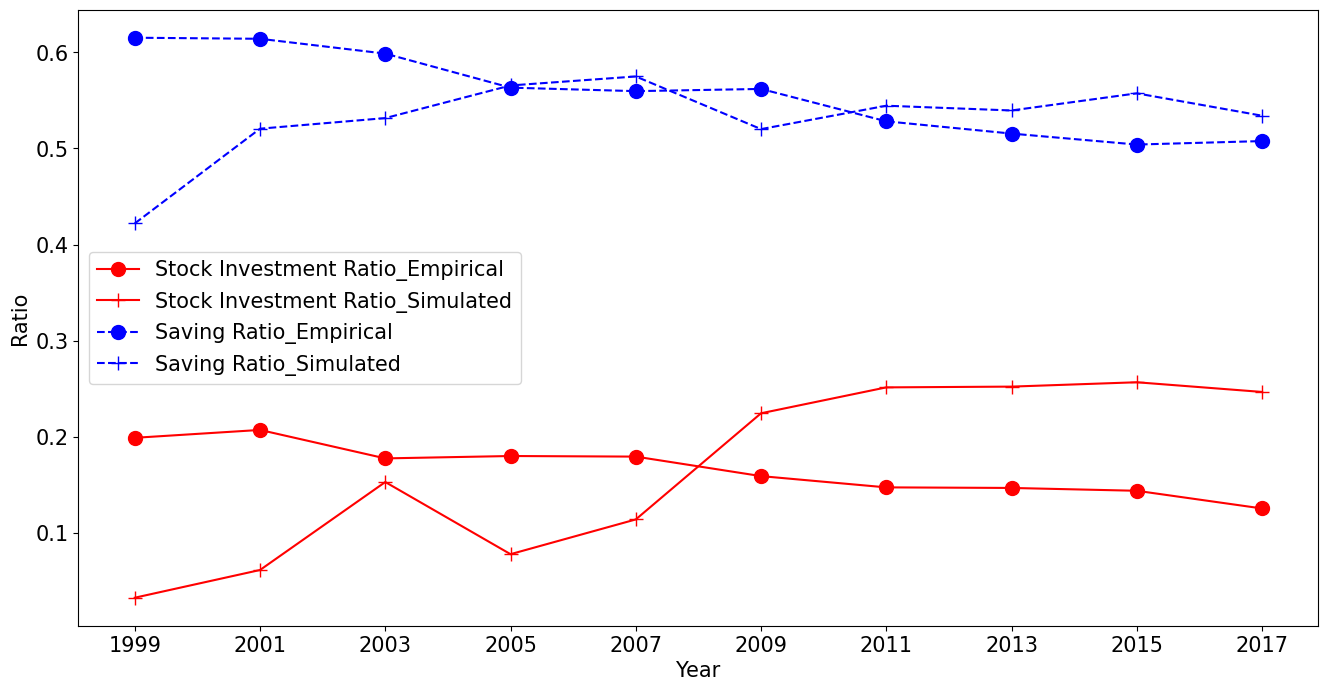

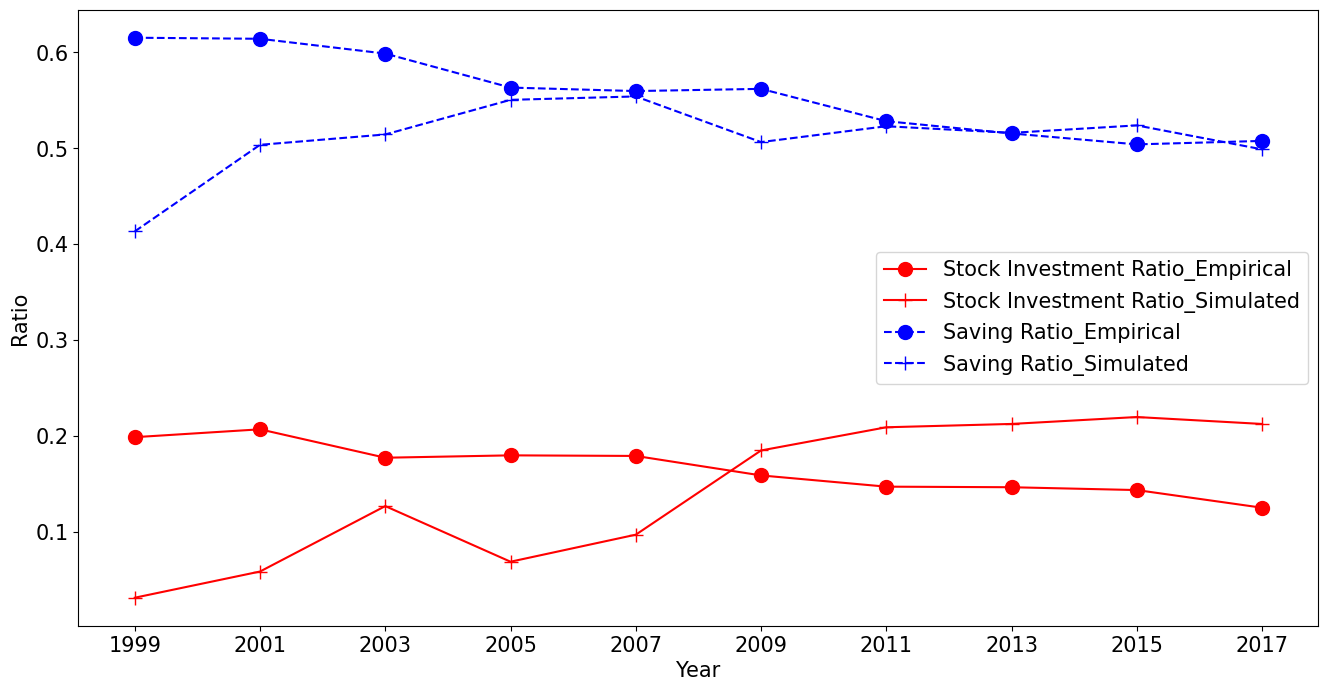

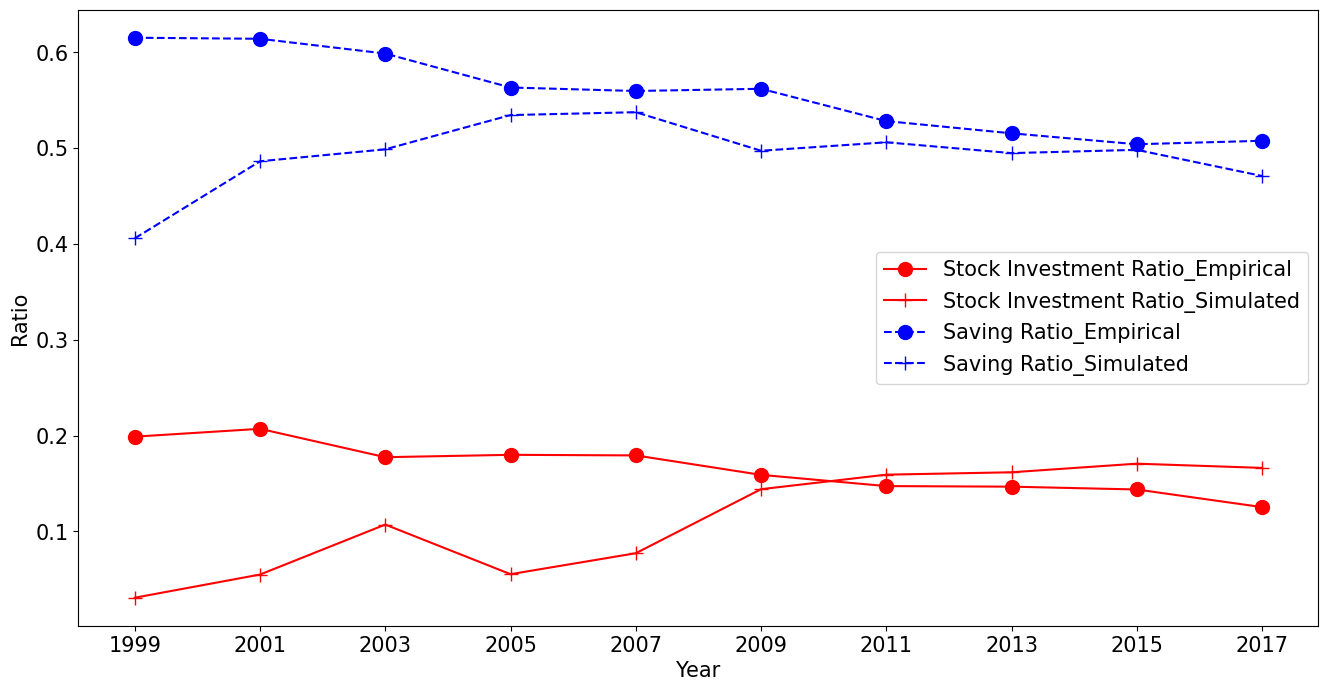

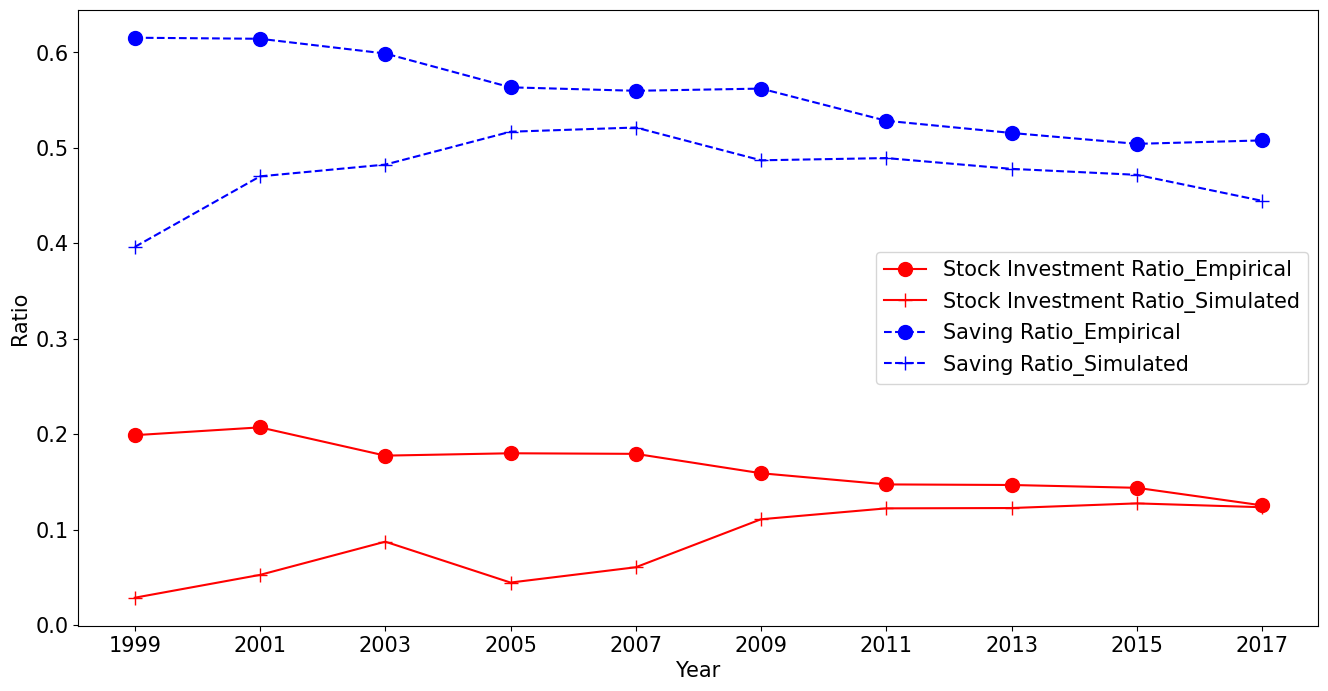

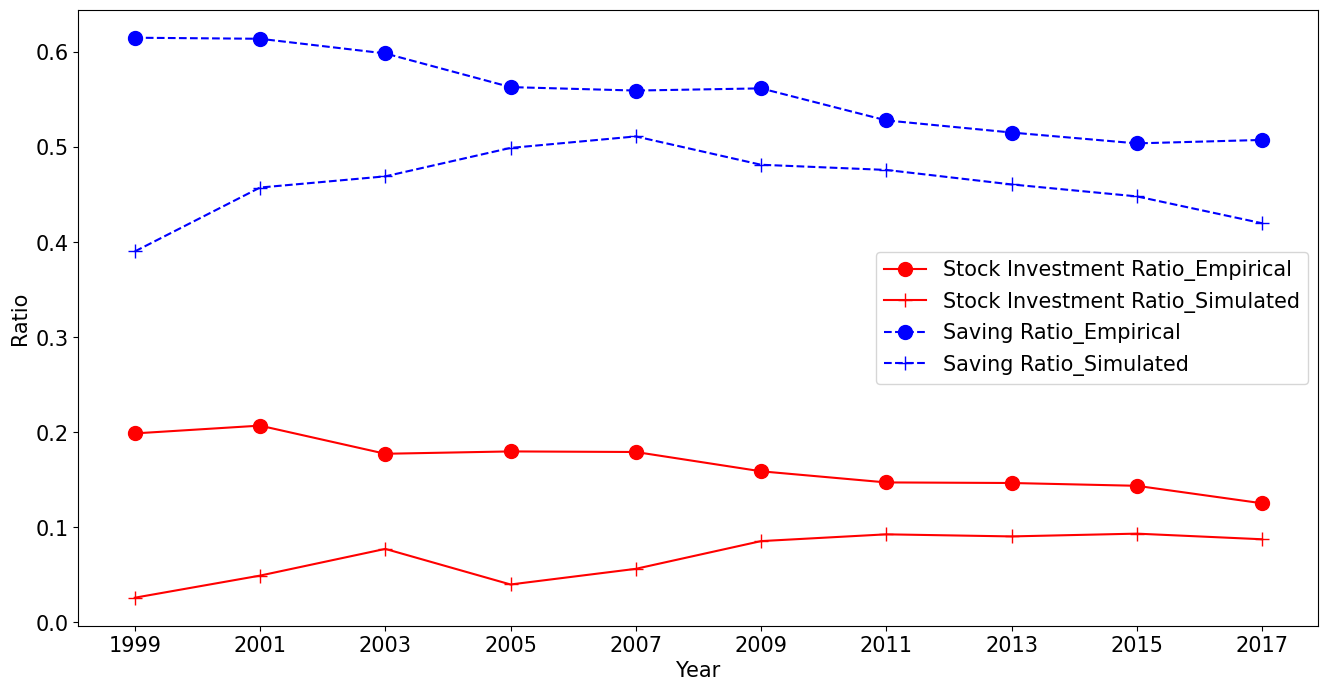

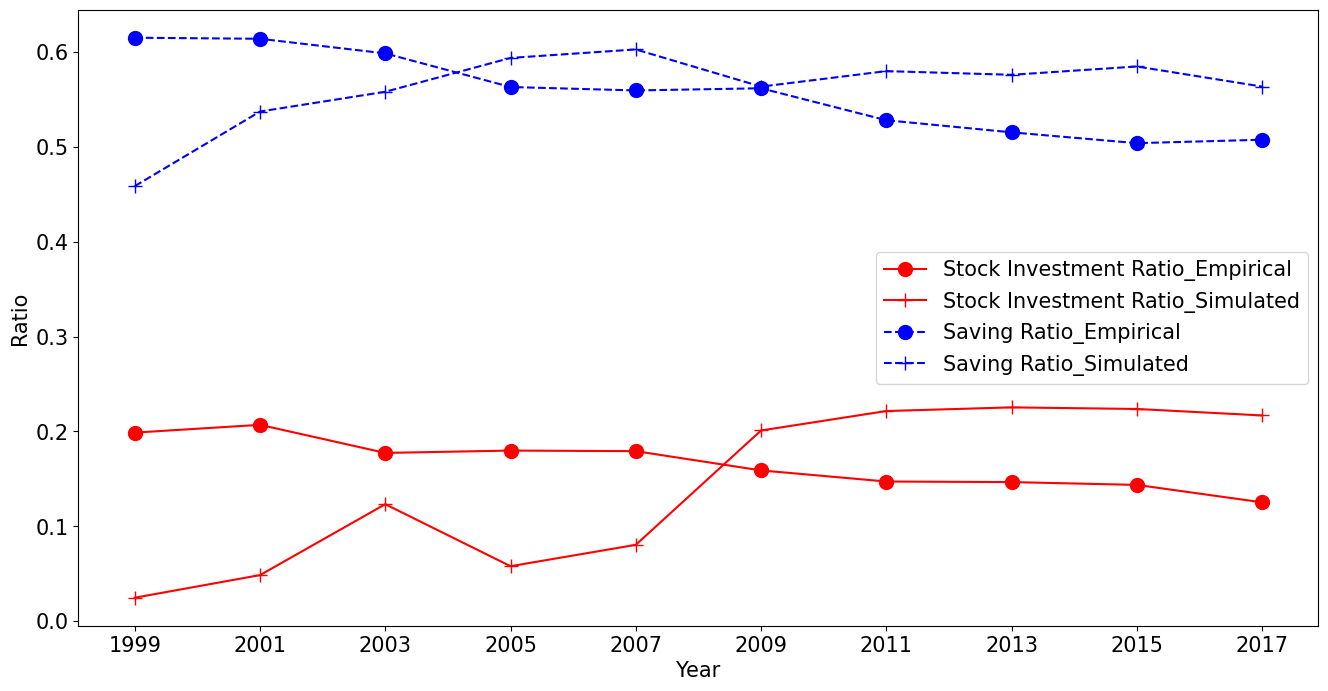

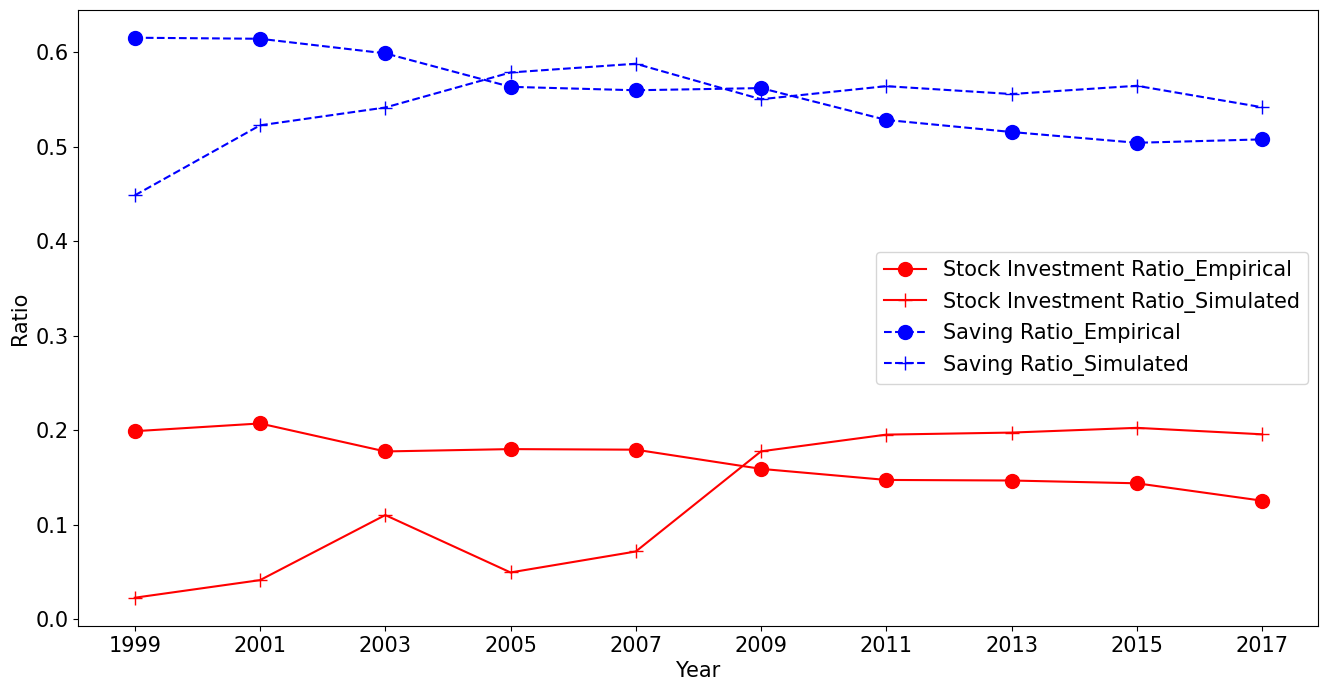

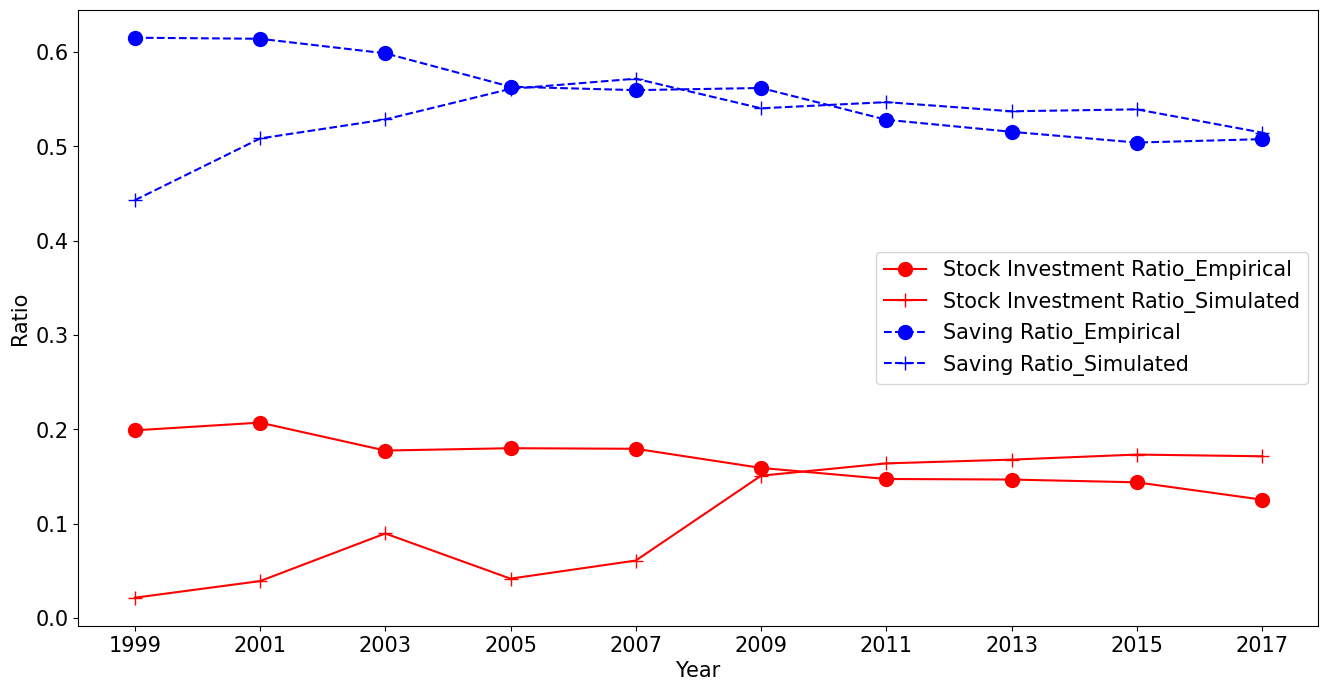

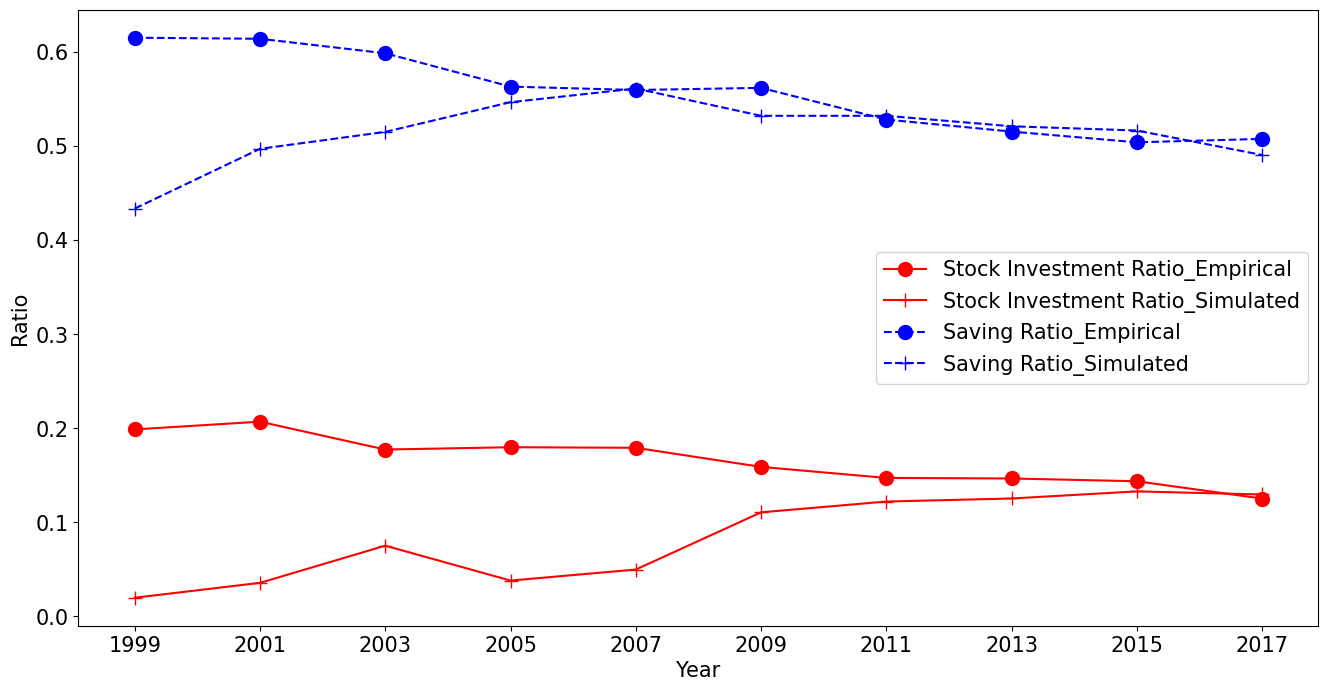

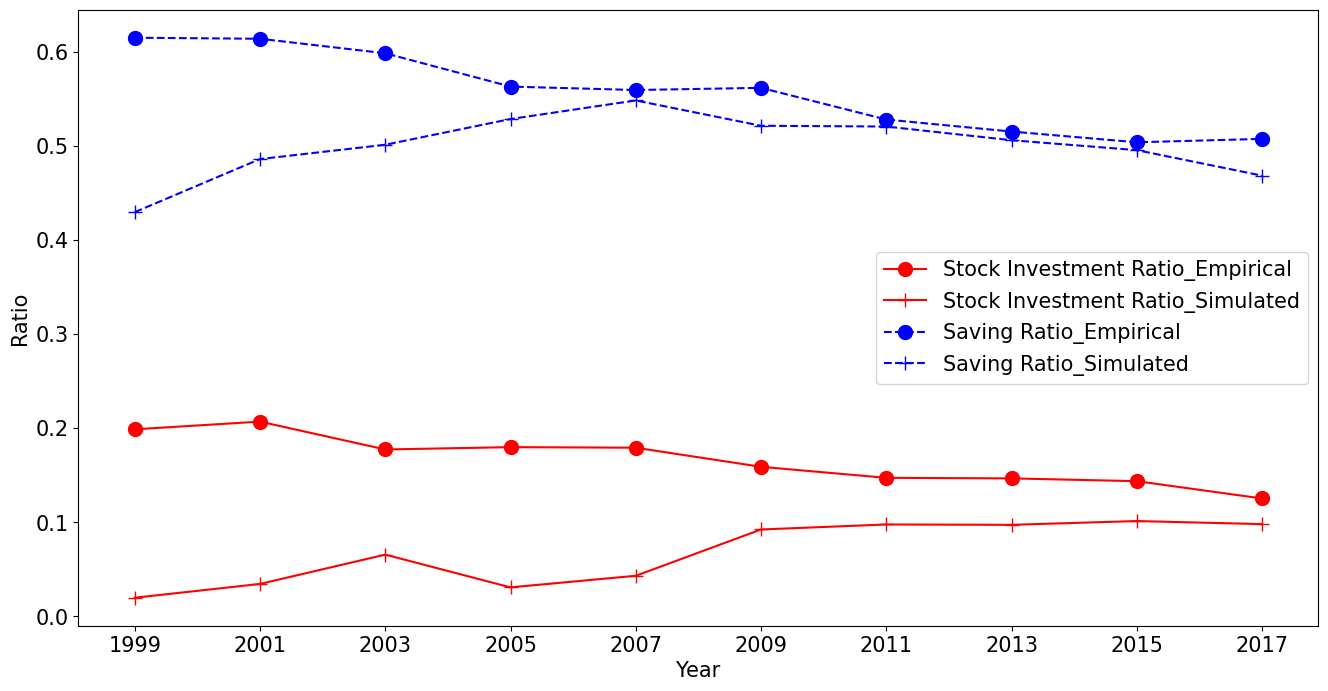

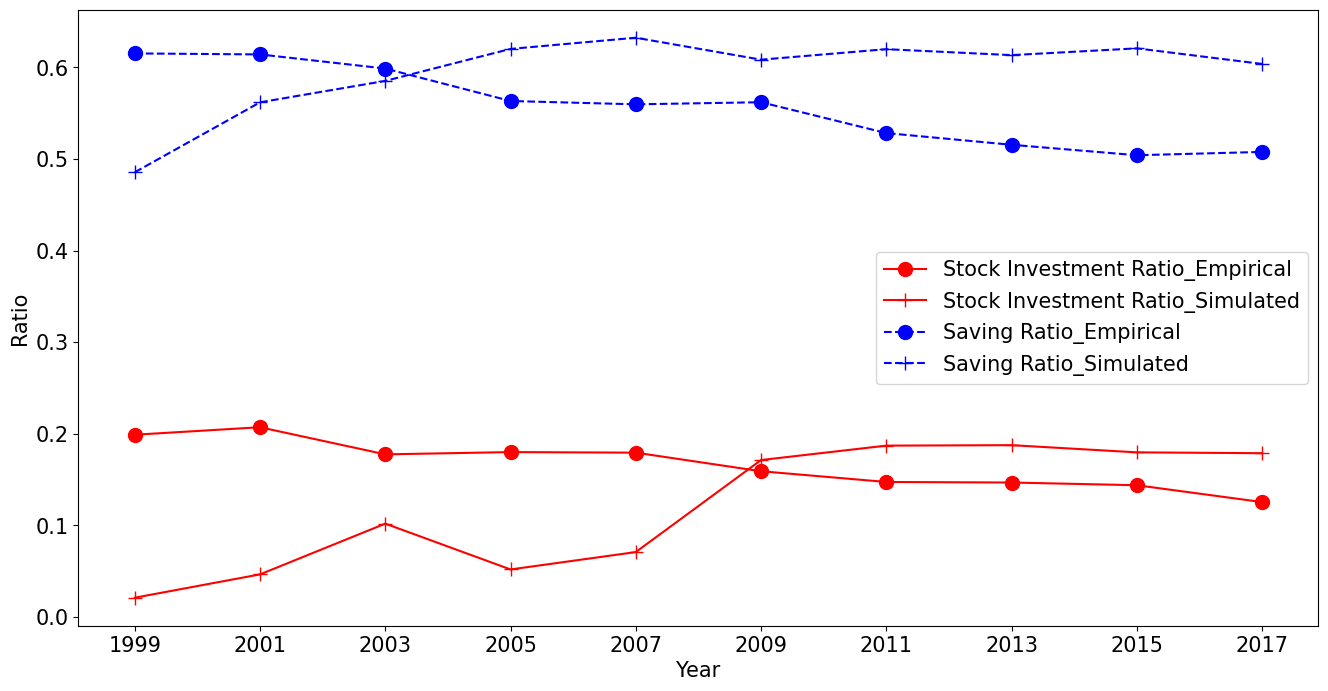

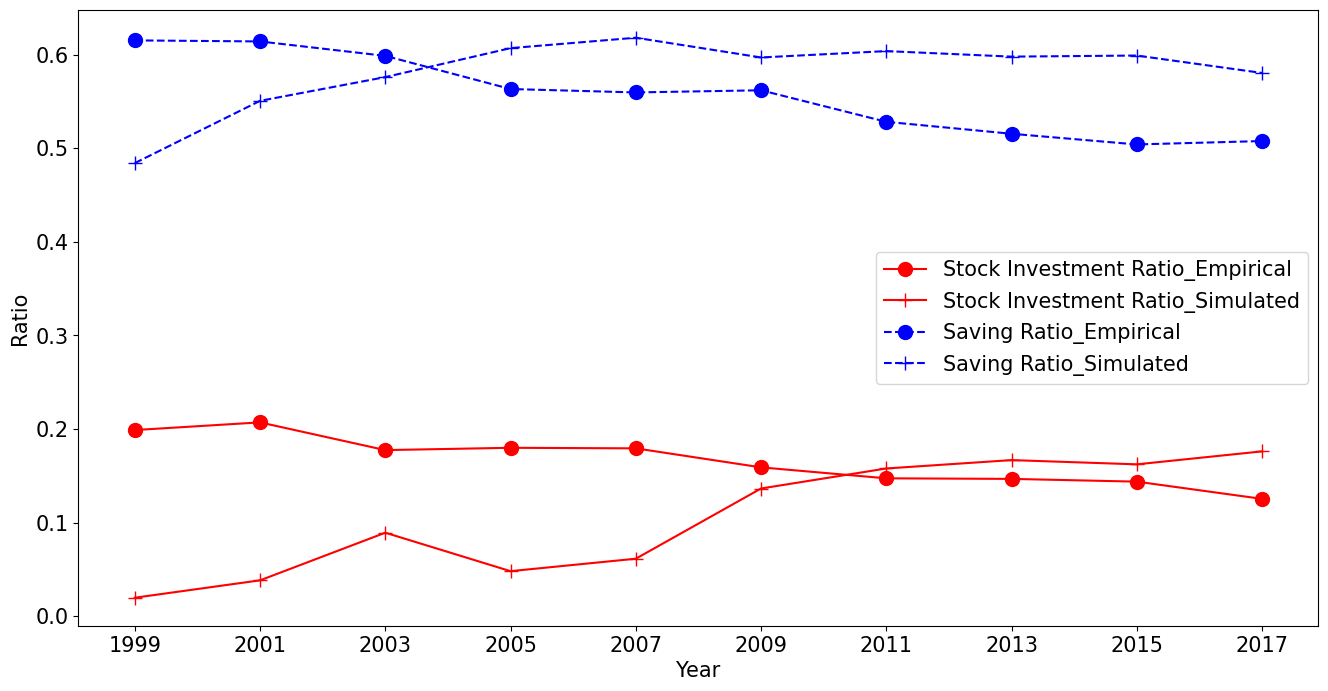

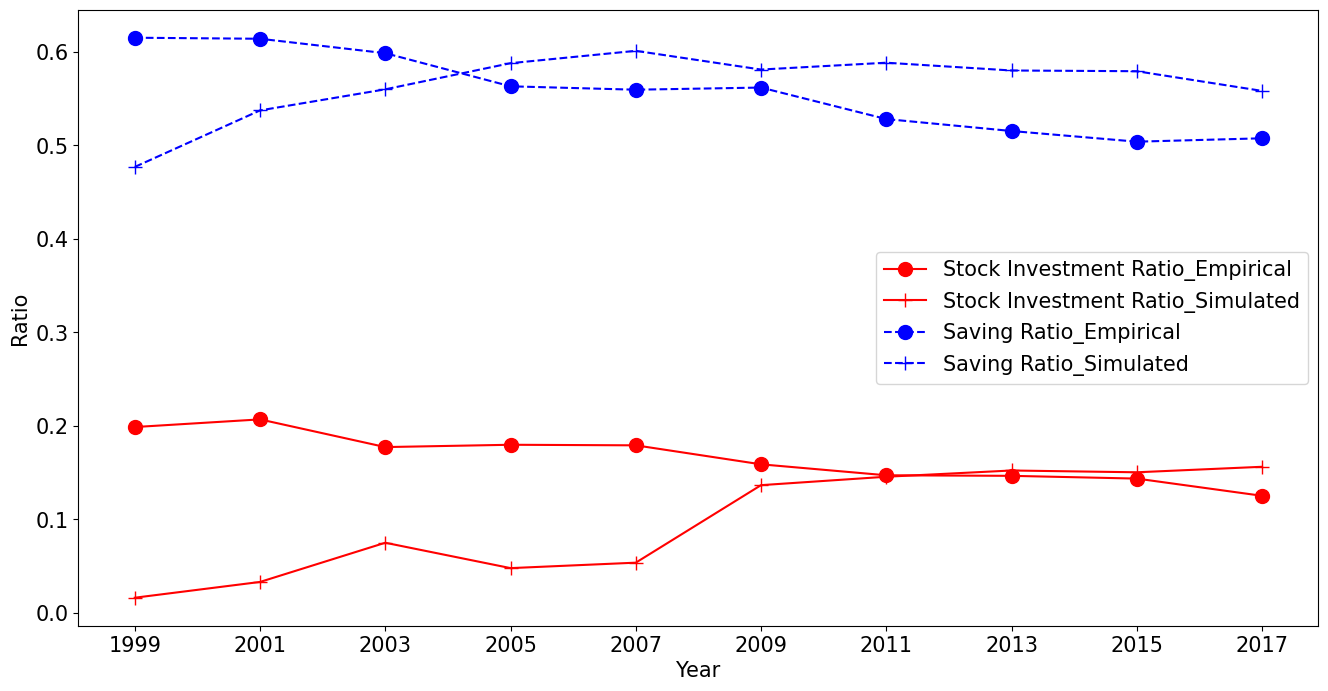

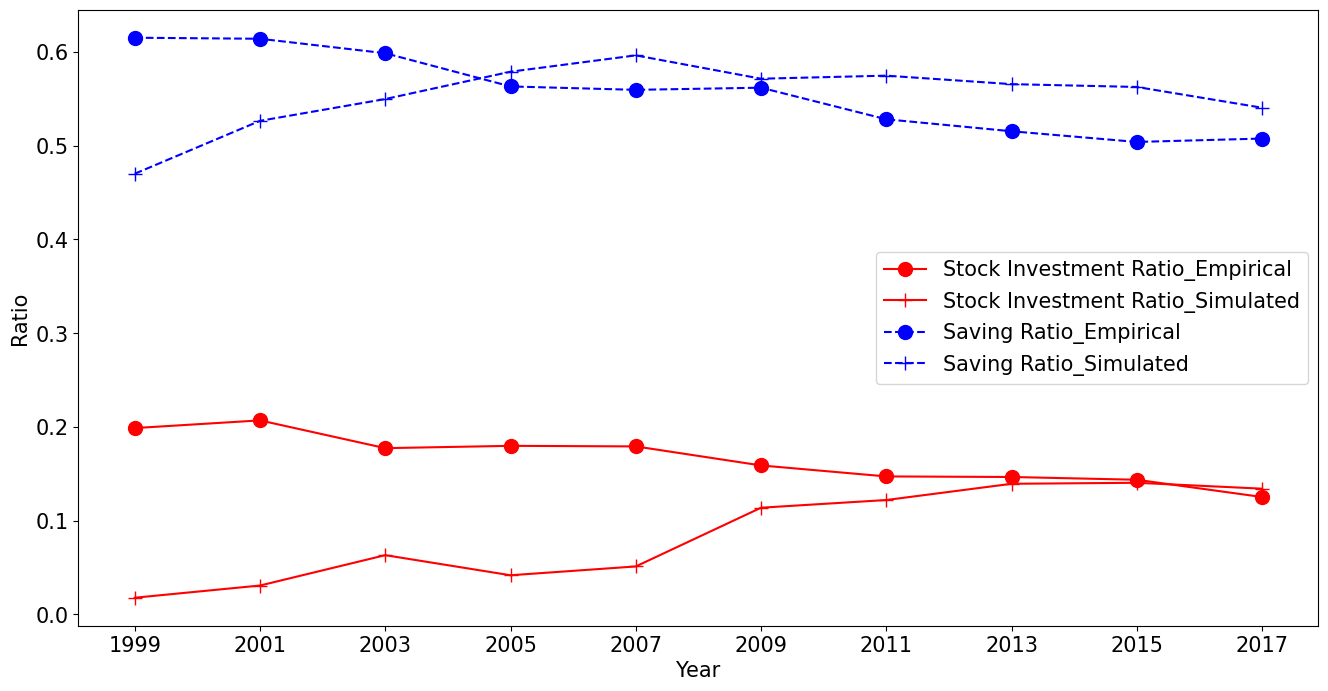

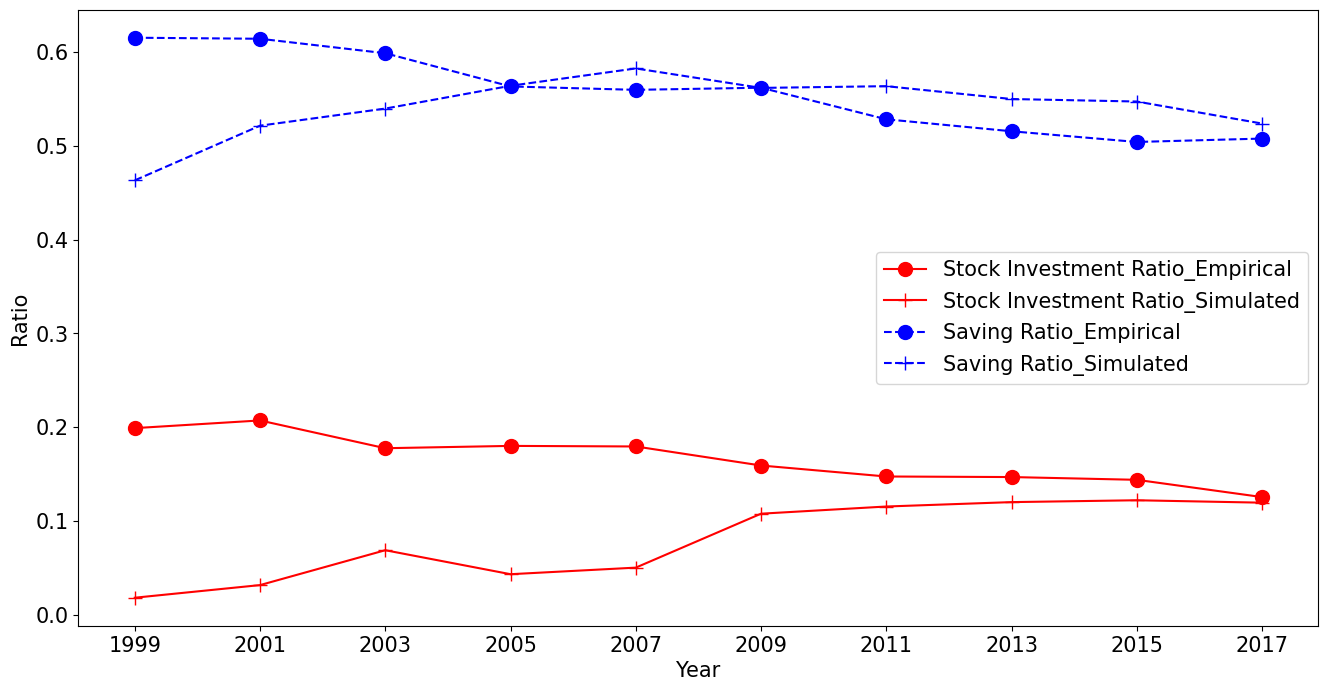

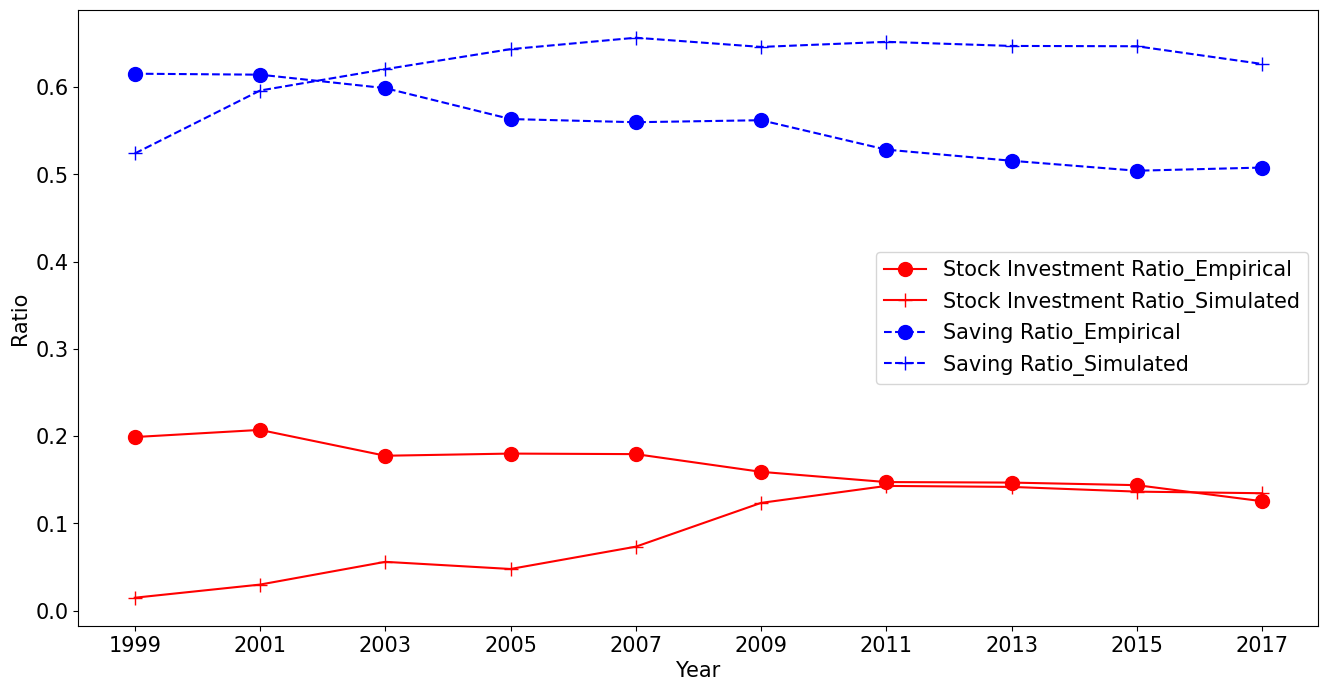

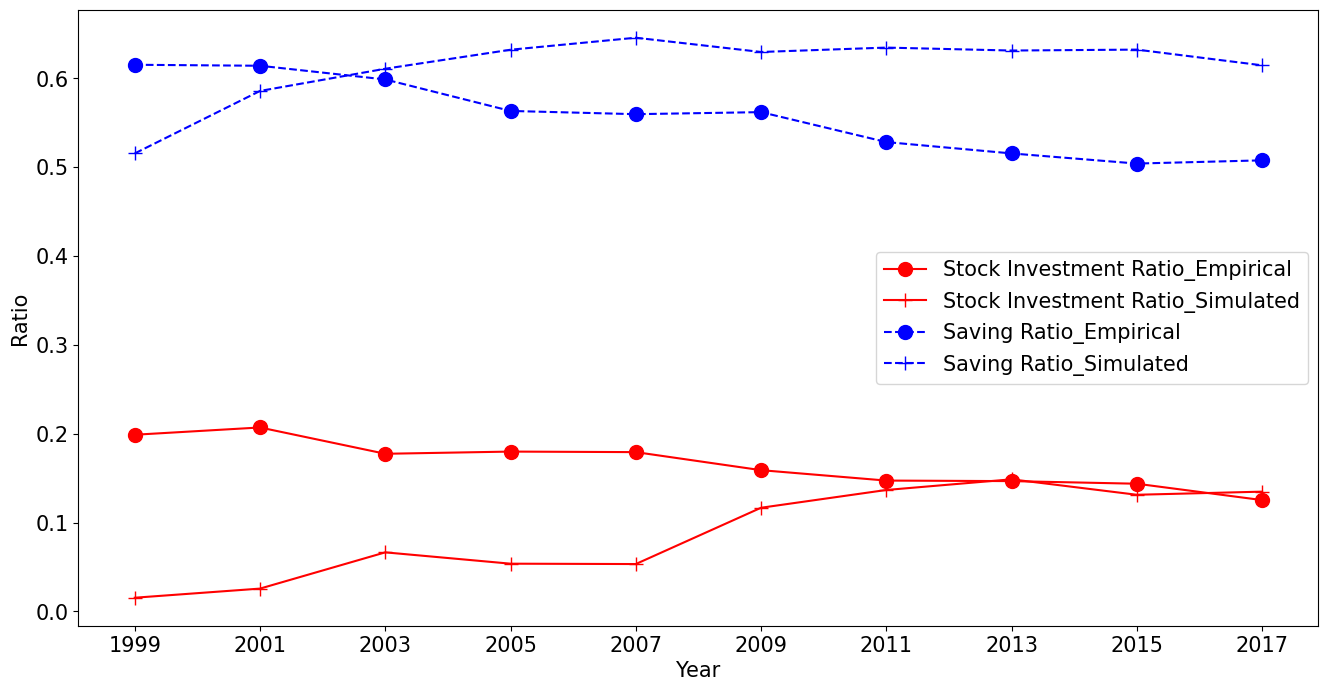

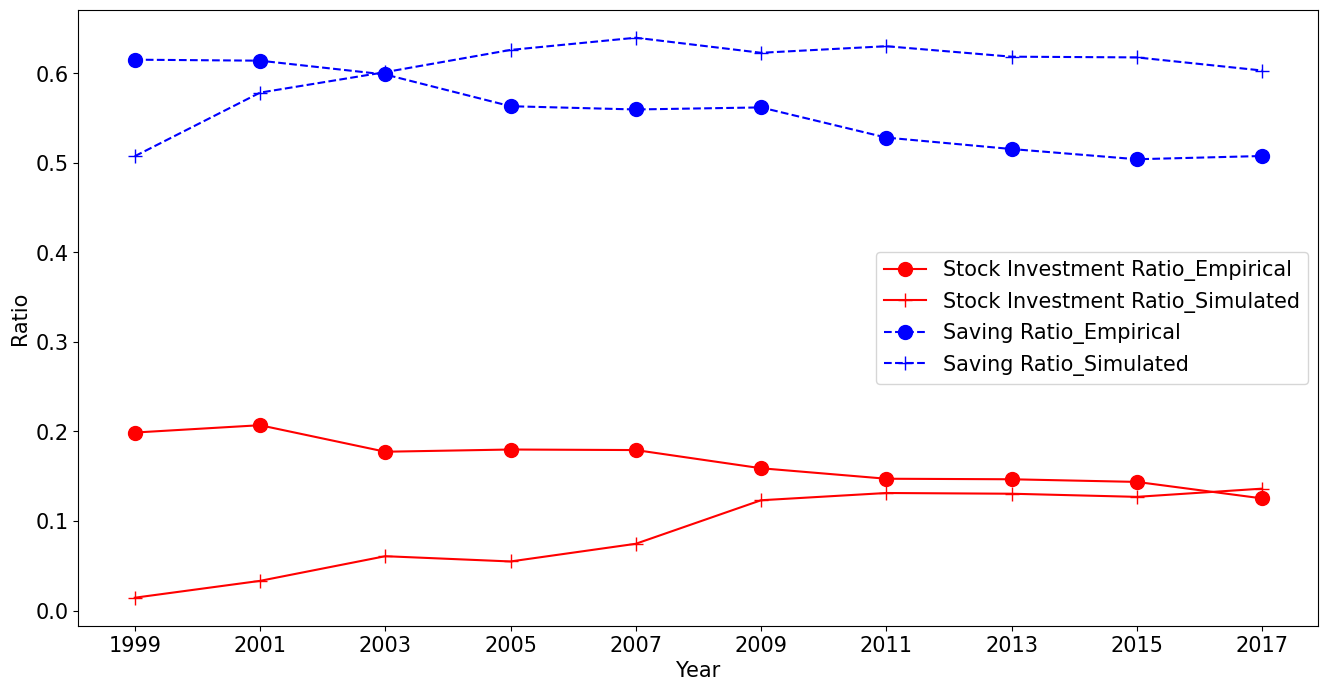

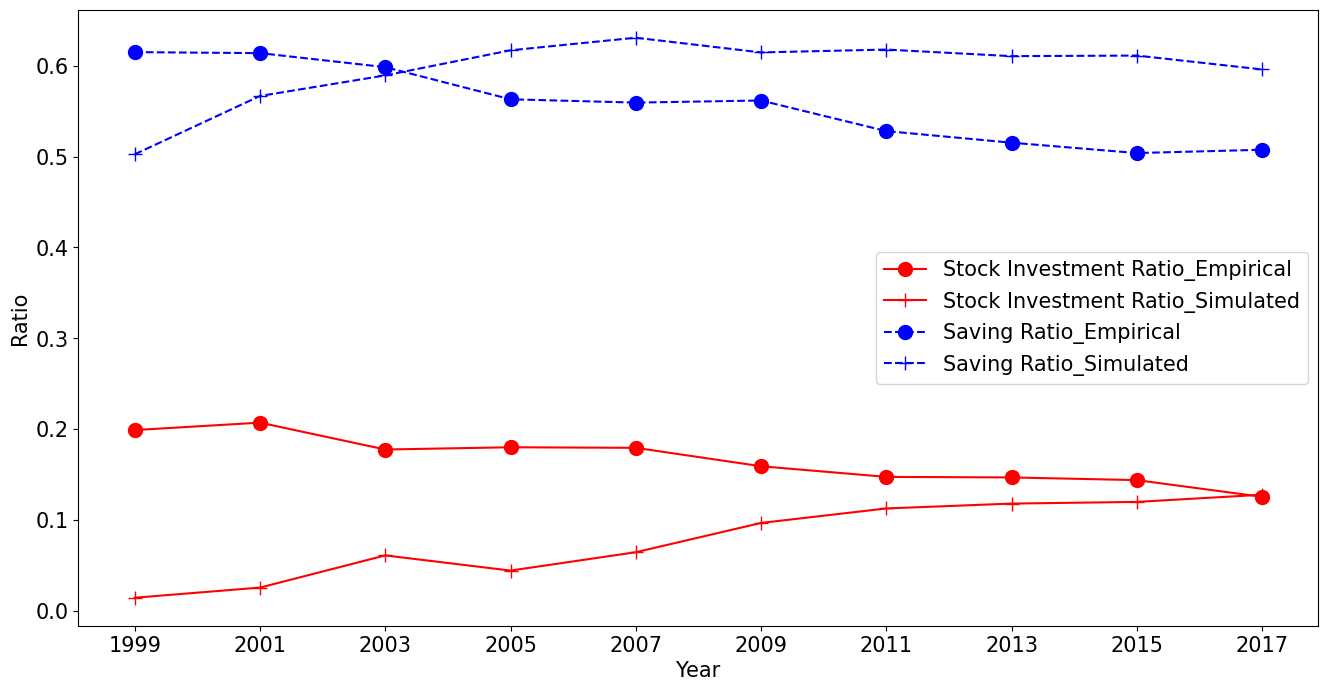

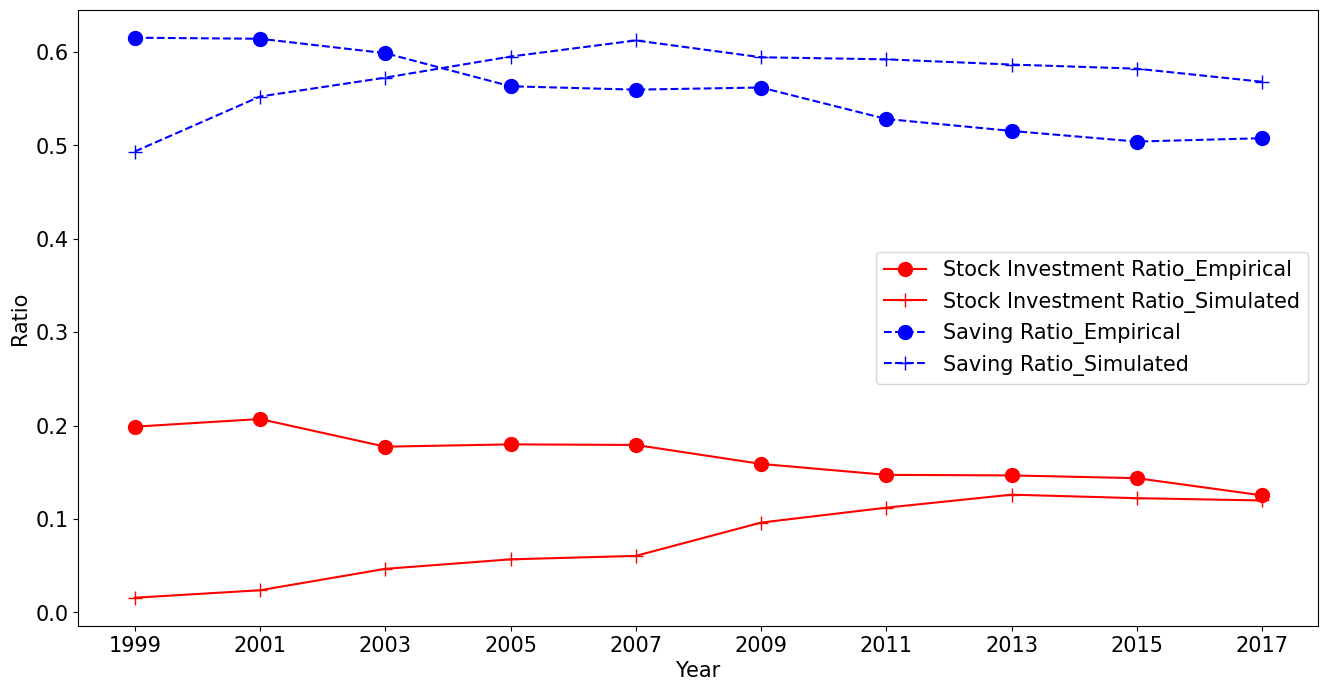

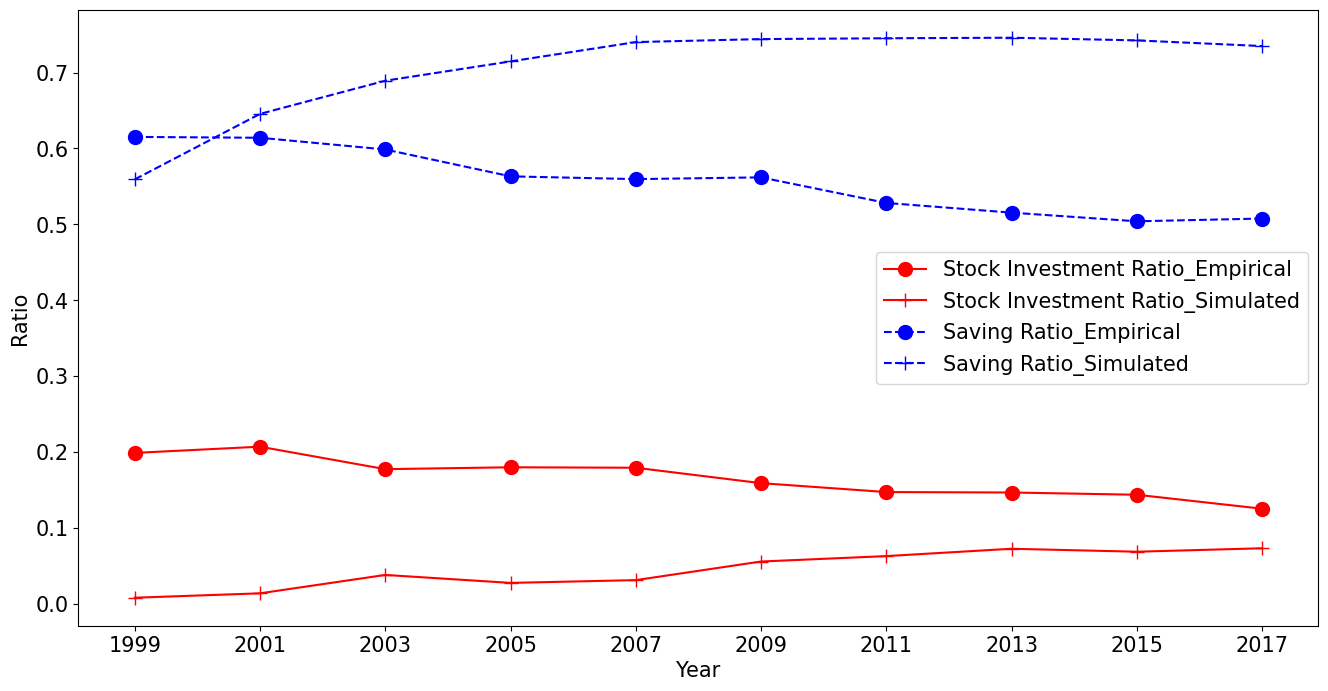

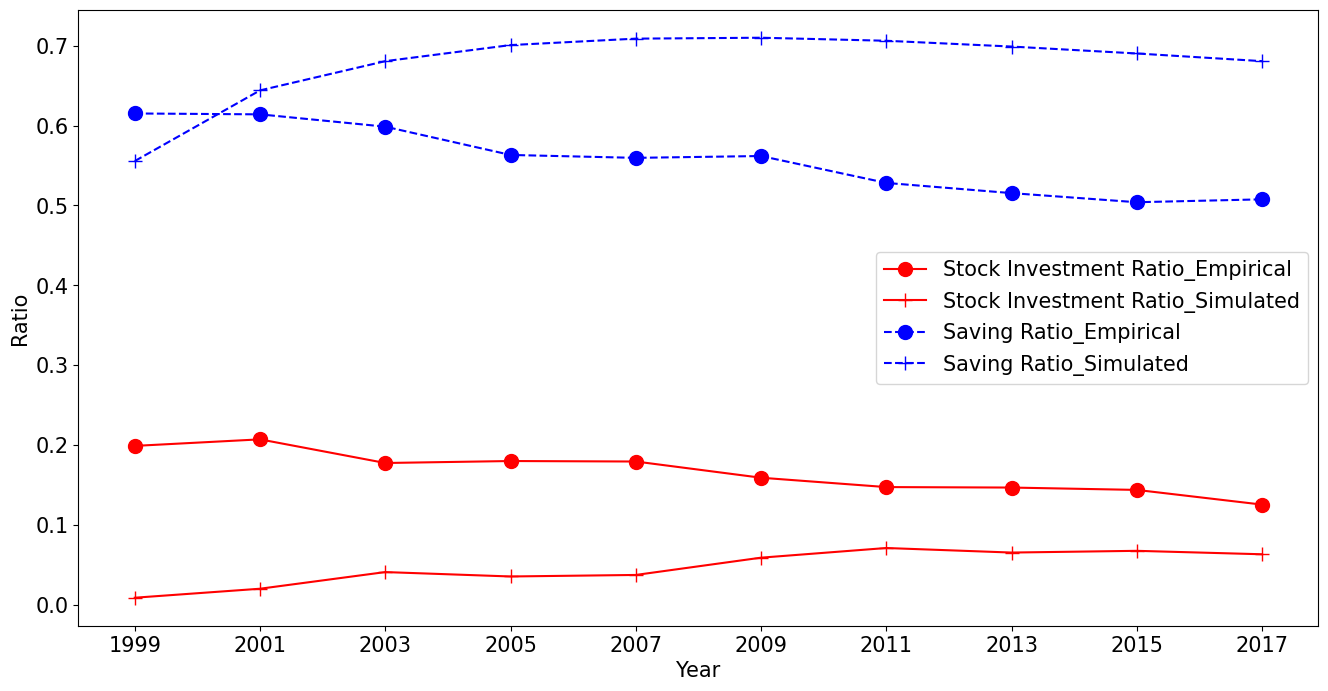

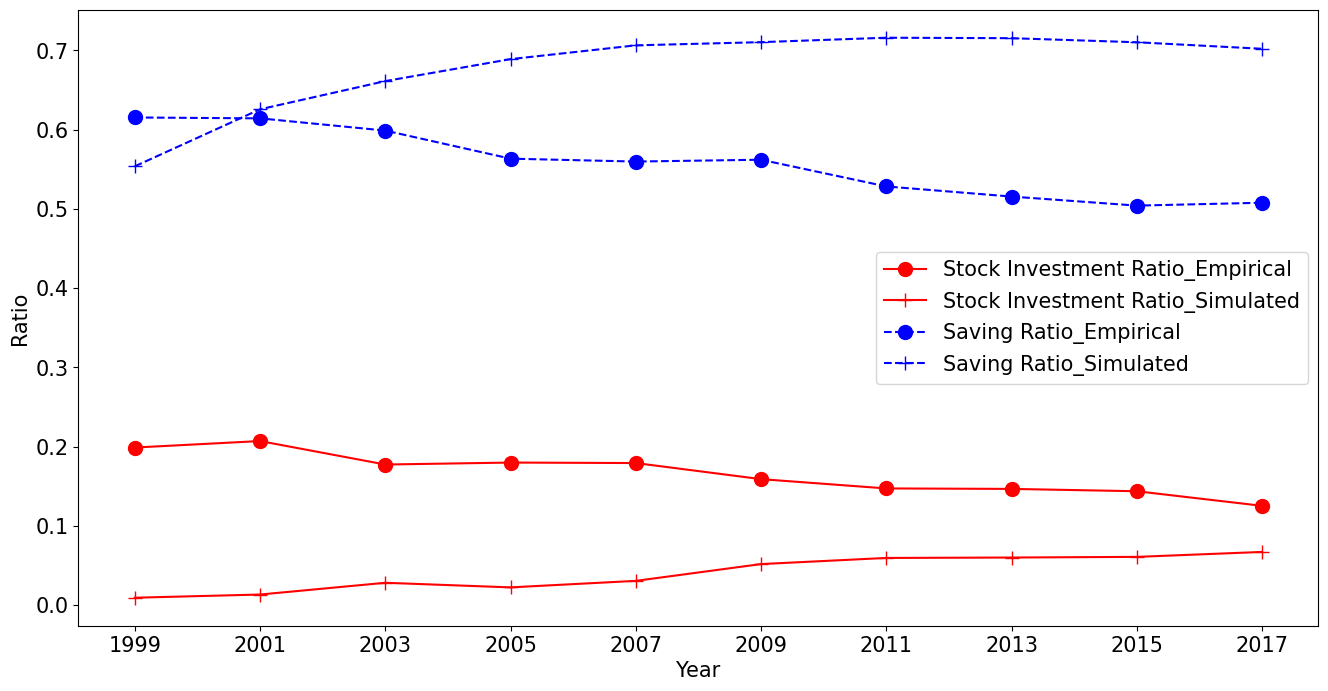

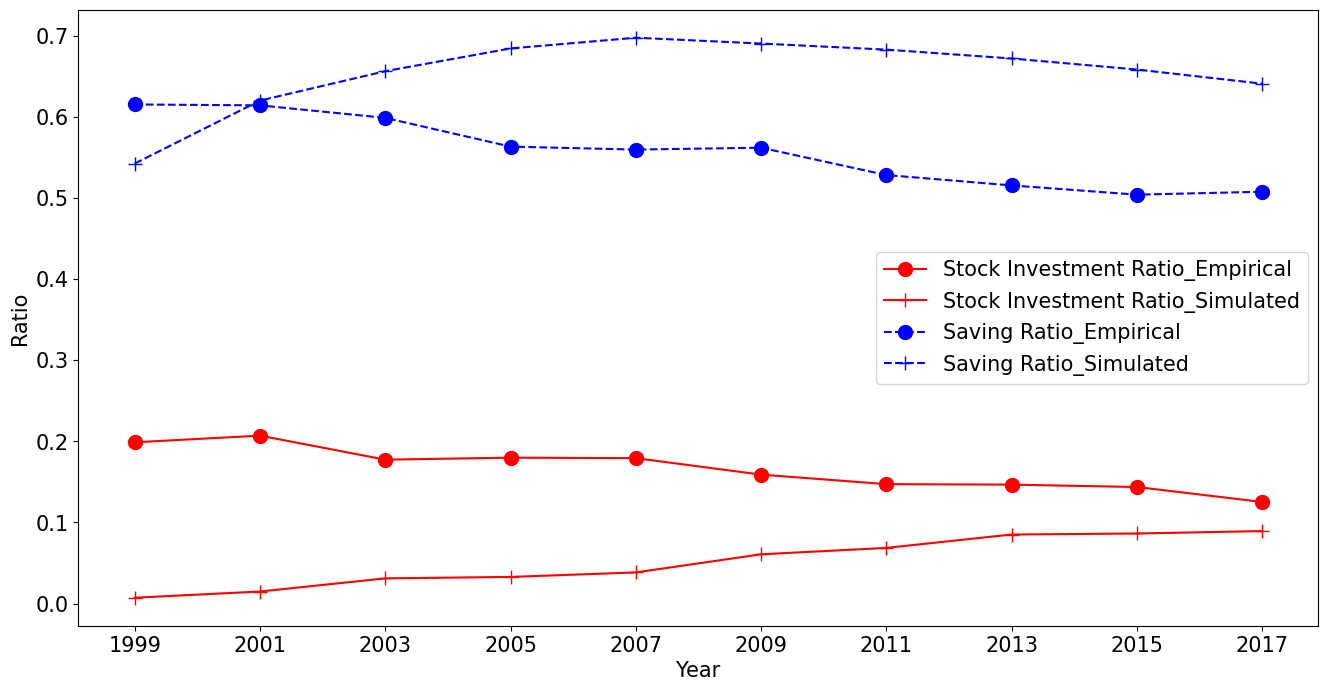

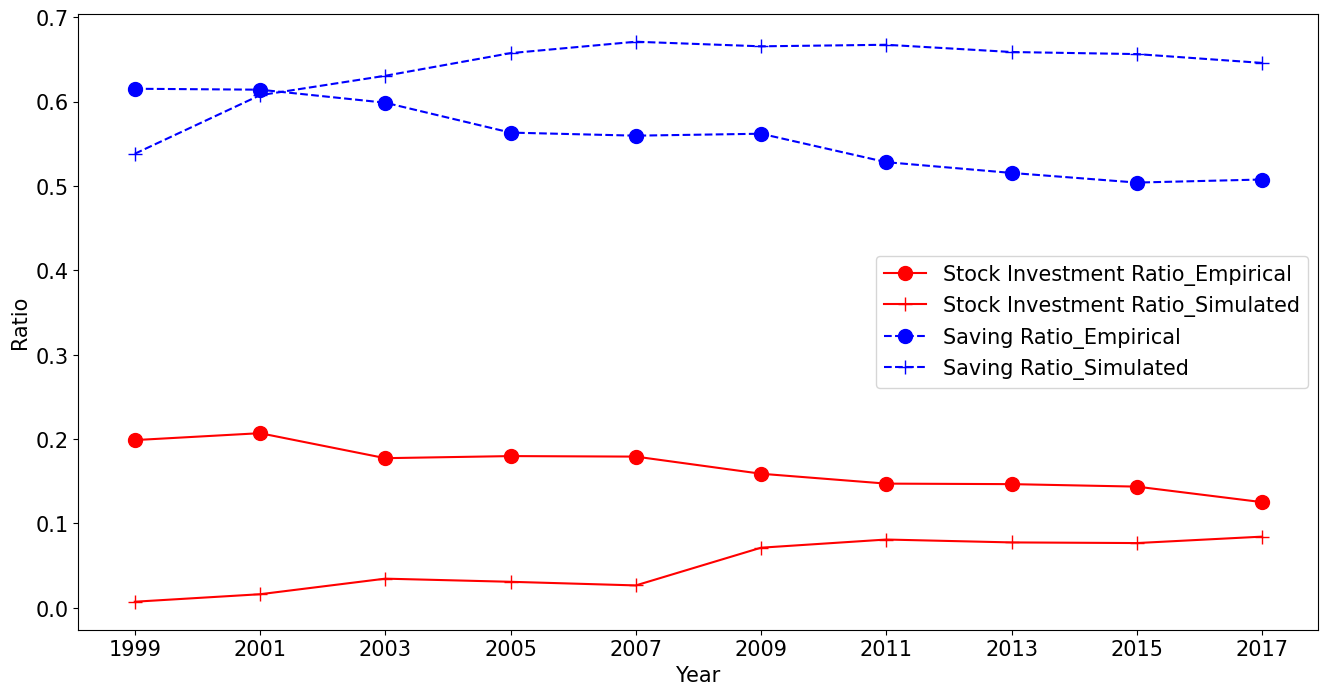

In [105]:
stockInvestmentRatioCollect = []
savingRatioCollect = []
stockInvestmentRatioCollectTrue = []
savingRatioCollectTrue = []
for gamma in Gamma:
    for beta_r in Beta_r:
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = variables(gamma, beta_r)
        plt.figure()
        plt.xlabel("Year")
        plt.xticks(years[:-1])
        plt.ylabel("Ratio")
        stockRatio_empirical = []
        savingRatio_empirical = []
        stockRatio_simulated = []
        savingRatio_simulated = []
        for year in years[:-1]:
            # in that particular year and in that particular age group 
            df = Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]
            # empirical stock investment ratio
            stockRatio_empirical.append((df.investmentAmount / (df.liquidWealth + df.investmentAmount)).mean()) 
            # empirical saving ratio 
            savingRatio_empirical.append(((df.investmentAmount + df.liquidWealth + df.laborIncome)/
                                          (df.laborIncome + df.liquidWealth + df.totalExpense + df.investmentAmount)).mean())
            w = wwww[year - years[0],:]
            b = bbbb[year - years[0],:]
            k = kkkk[year - years[0],:]
            c = cccc[year - years[0],:]
            h = cccc[year - years[0],:]
            o = oooo[year - years[0],:]
            balance = mmmm[year - years[0],:]
            stockRatio_simulated.append((k/(b+k+c+(1-o)*h*pr+ o*m*(balance>0))).mean())
            savingRatio_simulated.append((b+k).mean()/(c+(1-o)*h*pr+ o*m*(balance>0)+b+k).mean())
        meanSaving_empirical = round(np.mean(savingRatio_empirical), 3)
        meanInvestment_empirical = round(np.mean(stockRatio_empirical), 3)
        meanSaving_simulated = round(np.mean(savingRatio_simulated), 3)
        meanInvestment_simulated = round(np.mean(stockRatio_simulated), 3)
        # plt.title("Gamma: " + str(gamma) +  "   Beta: " + str(round(1/(1+beta_r),3)) + 
        #           "\n   Mean savingRatio simulated:   " + str(meanSaving_simulated) +
        #           "\n   Mean investmentRatio simulated:   " + str(meanInvestment_simulated) 
        #          )
        plt.plot(years[:-1], stockRatio_empirical, 'ro-', label = "Stock Investment Ratio_Empirical", markersize = 10)
        # plt.axhline(y=0.25, color='r', linestyle='--', label = "target_stockRatio")
        plt.plot(years[:-1], stockRatio_simulated, 'r+-', label = "Stock Investment Ratio_Simulated", markersize = 10)
        
        plt.plot(years[:-1], savingRatio_empirical, 'bo--', label = "Saving Ratio_Empirical", markersize = 10)
        # plt.axhline(y=0.40, color='b', linestyle='--', label = "target_savingRatio")
        plt.plot(years[:-1], savingRatio_simulated, 'b+--', label = "Saving Ratio_Simulated", markersize = 10)
        
        stockInvestmentRatioCollect.append(stockRatio_simulated)
        stockInvestmentRatioCollectTrue.append(stockRatio_empirical)
        savingRatioCollect.append(savingRatio_simulated)
        savingRatioCollectTrue.append(savingRatio_empirical)
        plt.legend()

In [106]:
liquidWealthCollect = []
consumptionCollect = []
investmentAmountCollect = []
bondInvestmentCollect = []
participationCollect = []
ownershipCollect = []
for gamma in Gamma:
    for beta_r in Beta_r:
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = variables(gamma, beta_r) 
        liquidWealthCollect.append(wwww.mean(axis = 1))
        consumptionCollect.append(cccc.mean(axis = 1))
        investmentAmountCollect.append(kkkk.mean(axis = 1))
        bondInvestmentCollect.append(bbbb.mean(axis = 1))
        participationCollect.append((kkkk>1).mean(axis = 1))
        ownershipCollect.append((oooo).mean(axis = 1))

### GMM 

In [107]:
# simulated results 
stockInvestmentRatioCollect = np.array(stockInvestmentRatioCollect)
savingRatioCollect = np.array(savingRatioCollect)
stockInvestmentRatioCollectE = np.array(stockInvestmentRatioCollectTrue[0])
savingRatioCollectE = np.array(savingRatioCollectTrue[0])
liquidWealthCollect = np.array(liquidWealthCollect)
consumptionCollect = np.array(consumptionCollect)
investmentAmountCollect = np.array(investmentAmountCollect)
bondInvestmentCollect = np.array(bondInvestmentCollect)
participationCollect = np.array(participationCollect)
ownershipCollect = np.array(ownershipCollect)


targetMean = np.array([savingRatioCollectE.mean(), stockInvestmentRatioCollectE.mean(), liquidWealth_mean.mean(), 
                        consumption_mean.mean(),
                        investmentStock_mean.mean(), 
                        (bondOrcash_mean + laborIncome_mean/2).mean(), 
                        0.45,
                        np.mean(ownershipStatus_mean)])

empriricalMean = [savingRatioCollect, stockInvestmentRatioCollect, liquidWealthCollect, 
                    consumptionCollect, investmentAmountCollect, bondInvestmentCollect,
                     participationCollect, ownershipCollect]

optimalBetas = []
optimalGammas = []

BetaGamma = [[b,r] for r in Gamma for b in Beta_r ]

for weightsIndex in range(2,8):
    weights = np.ones(len(targetMean))/len(targetMean)
    # making participation and ownership more important
    #weights[weightsIndex] = 2
    errors = []
    for i in range(len(Beta_r)*len(Gamma)):
        matchMean = np.zeros(len(targetMean))
        for j in range(len(targetMean)):
            if j >=2 and j <= 5:
                matchMean[j] = ((empriricalMean[j][i] - targetMean[j])/np.std((empriricalMean[j][i] - targetMean[j]))).mean()
        errors.append(np.dot(weights, matchMean*matchMean))
    beta_opt, gamma_opt = BetaGamma[np.argmin(errors)]
    print("Beta Value: ", 1 / (1 + beta_opt))
    print("Gamma Value: ", gamma_opt)

    optimalBetas.append(beta_opt)
    optimalGammas.append(gamma_opt)

Beta Value:  0.9615384615384615
Gamma Value:  4.0
Beta Value:  0.9615384615384615
Gamma Value:  4.0
Beta Value:  0.9615384615384615
Gamma Value:  4.0
Beta Value:  0.9615384615384615
Gamma Value:  4.0
Beta Value:  0.9615384615384615
Gamma Value:  4.0
Beta Value:  0.9615384615384615
Gamma Value:  4.0


In [108]:
i = BetaGamma.index([0.02, 4.0])

matchMean = np.zeros(len(targetMean))
for j in range(len(targetMean)):
        matchMean[j] = empriricalMean[j][i].mean() 

alternativeMatchMeanCollect = []
for b,g in zip(optimalBetas, optimalGammas):
        i = BetaGamma.index([b, g])
        alternativeMatchMean = np.zeros(len(targetMean))
        for j in range(len(targetMean)):
                alternativeMatchMean[j] = empriricalMean[j][i].mean() 
        alternativeMatchMeanCollect.append(np.round(alternativeMatchMean, 2))

In [109]:
data = {'variables':['savingRatio', 'stockInvestmentRatio', 'liquidWealth', 
                        'consumption', 'stockInvestmentAmount', 'bondInvestmentAmount',
                        'participationRatio','ownershipRatio'],
        'empiricalMeanValue':np.round(targetMean, 2),
        'simulatedMeanValue':np.round(matchMean, 2),
        }
print(pd.DataFrame(data).to_latex(index=False))

\begin{tabular}{lrr}
\toprule
            variables &  empiricalMeanValue &  simulatedMeanValue \\
\midrule
          savingRatio &                0.56 &                0.53 \\
 stockInvestmentRatio &                0.17 &                0.17 \\
         liquidWealth &               48.01 &               67.74 \\
          consumption &               35.80 &               39.61 \\
stockInvestmentAmount &               29.24 &               30.06 \\
 bondInvestmentAmount &               44.54 &               36.80 \\
   participationRatio &                0.45 &                0.45 \\
       ownershipRatio &                0.72 &                0.75 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2339334/1465777835.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(data).to_latex(index=False))


In [110]:
def simulatedPlot(value, title, targetValue = None, targetValues = None):
    plt.figure()
    #plt.title(title)
    plt.xticks(years)
    plt.xlabel("Year")
    plt.ylabel("Ownership Ratio")
    upperBound = value.max(axis = 0)
    lowerBound = value.min(axis = 0)
    if len(lowerBound) == 10:
        #plt.fill_between(range(1999, 2019, 2), lowerBound, upperBound)
        plt.plot(range(1999, 2019, 2),value[i], "b--", label = "Simulated")
    elif len(lowerBound) == 20:
        #plt.fill_between(range(1999, 2019), lowerBound, upperBound)
        plt.plot(range(1999, 2019),value[i], "b--", label = "Simulated")
    else:
        #plt.fill_between(range(1999, 2020), lowerBound, upperBound)
        plt.plot(range(1999, 2020),value[i], "b--", label = "Simulated")
    if(np.isscalar(targetValue)):
        plt.axhline(targetValue, "r-")
    elif(len(targetValue)==10):
        plt.plot(range(1999, 2019, 2), targetValue, "r-", label = "Empirical") 
    else:
        plt.plot(years, targetValue, "r-", label = "Empirical") 
    plt.legend()
    plt.show()

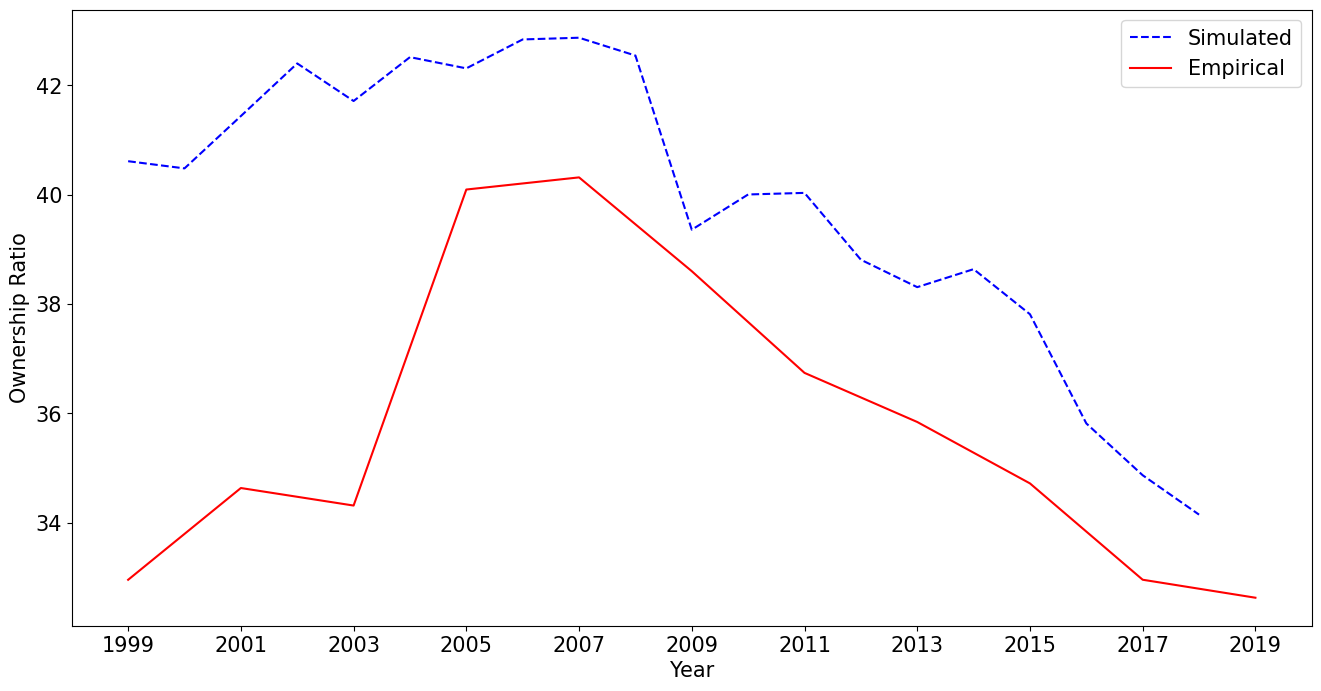

In [111]:
simulatedPlot(consumptionCollect, targetValue = consumption_mean, title = "Consumption Plot")

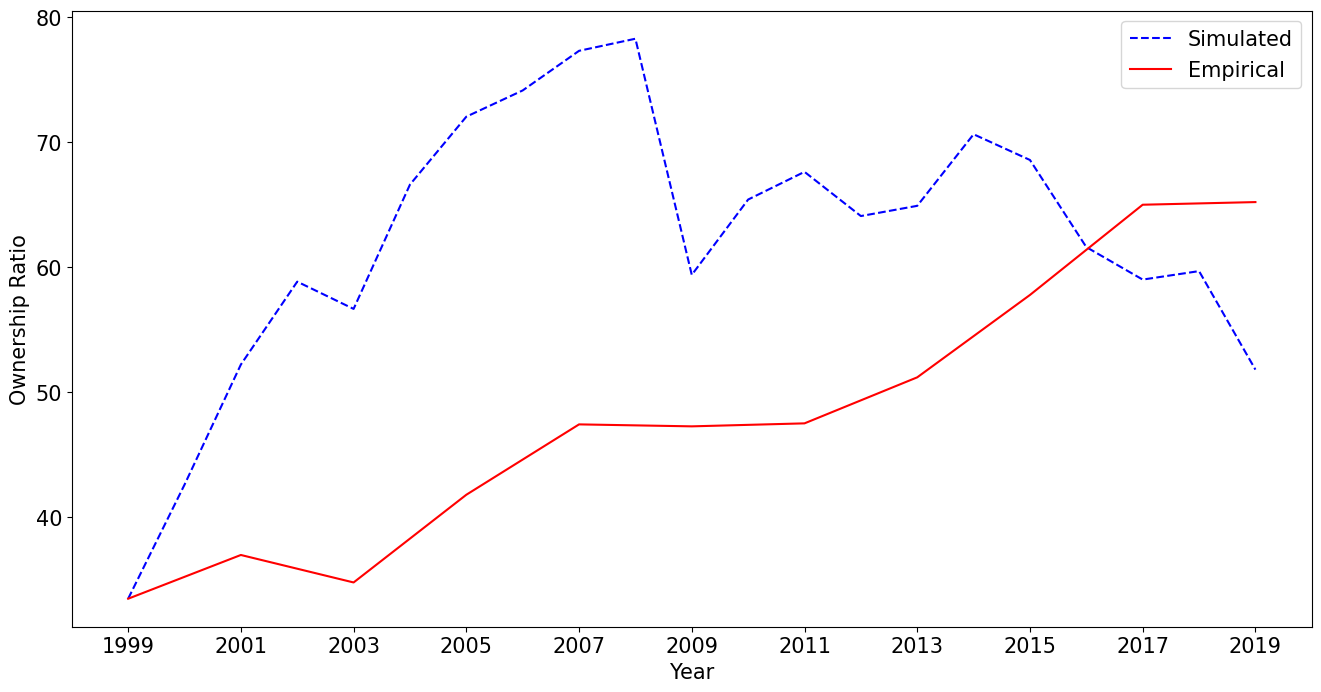

In [112]:
simulatedPlot(liquidWealthCollect, targetValue = liquidWealth_mean, title = "liquid wealth Plot")

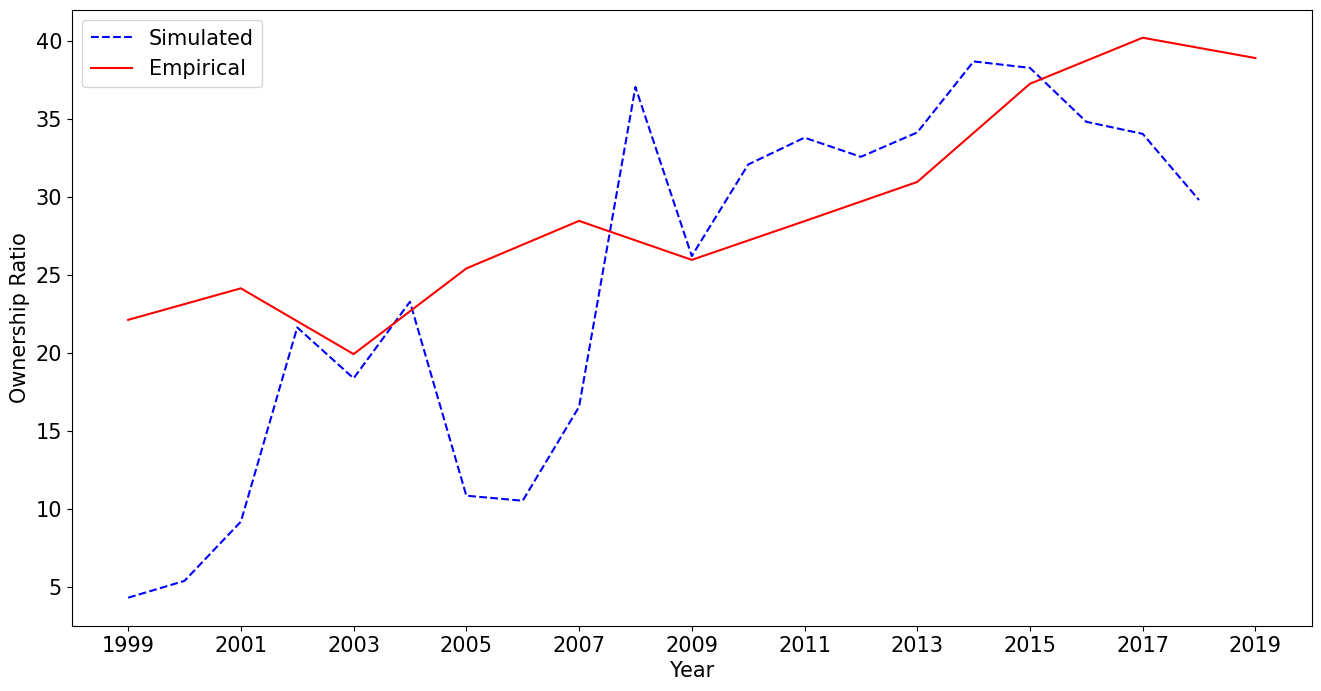

In [113]:
simulatedPlot(investmentAmountCollect, targetValue = investmentStock_mean, title = "InvestmentAmount Plot")

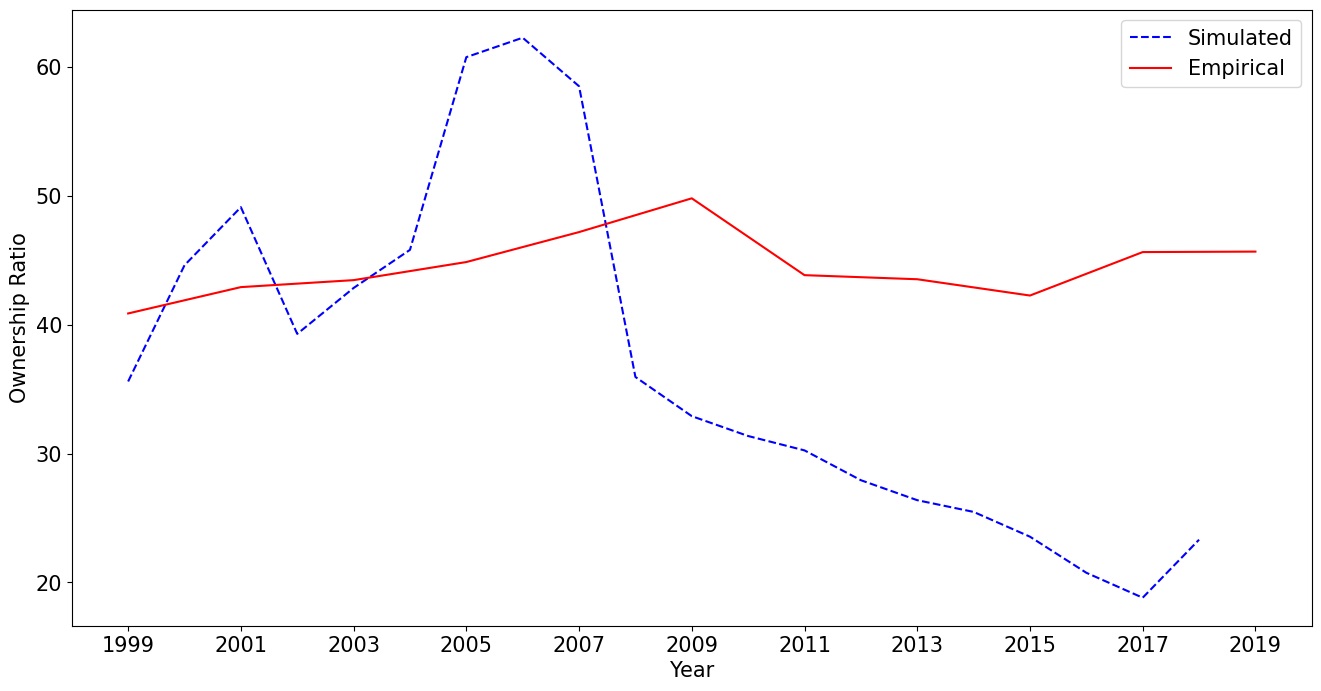

In [114]:
simulatedPlot(bondInvestmentCollect, targetValue = bondOrcash_mean + laborIncome_mean/2, title = "Bond Investment Plot")

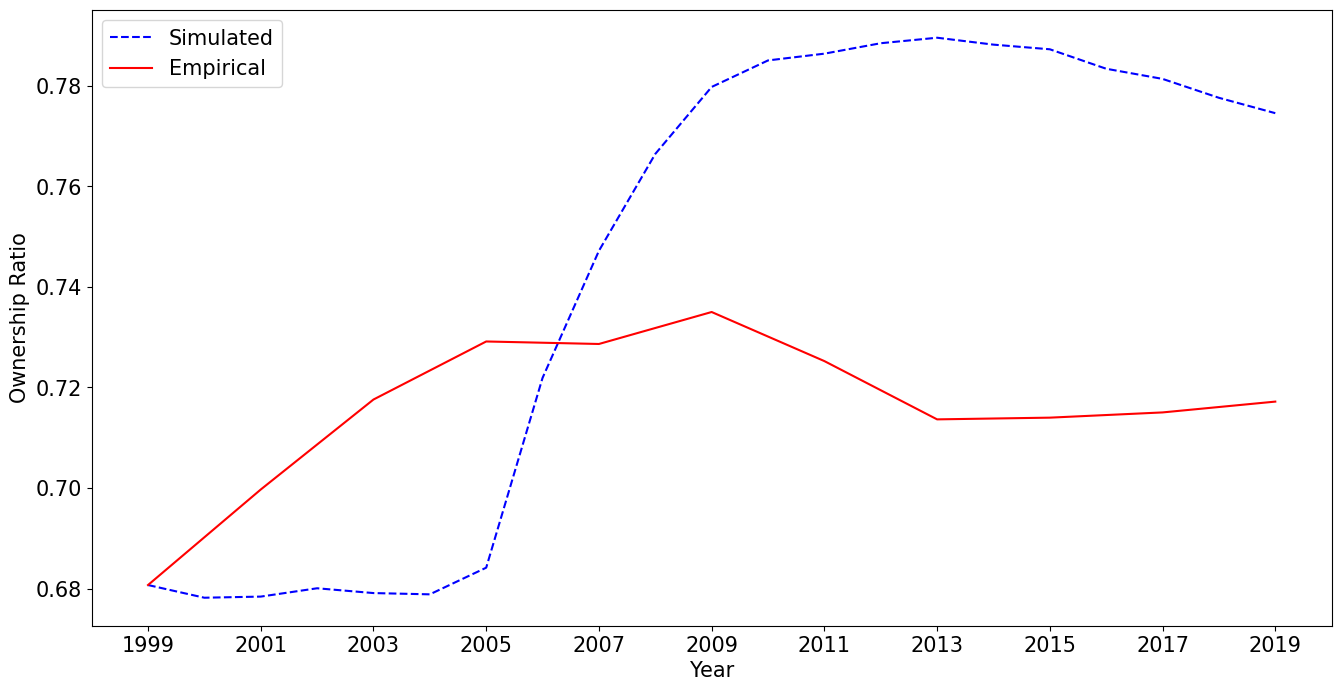

In [115]:
simulatedPlot(ownershipCollect, targetValue = ownershipStatus_mean, title = "Bond Investment Plot")

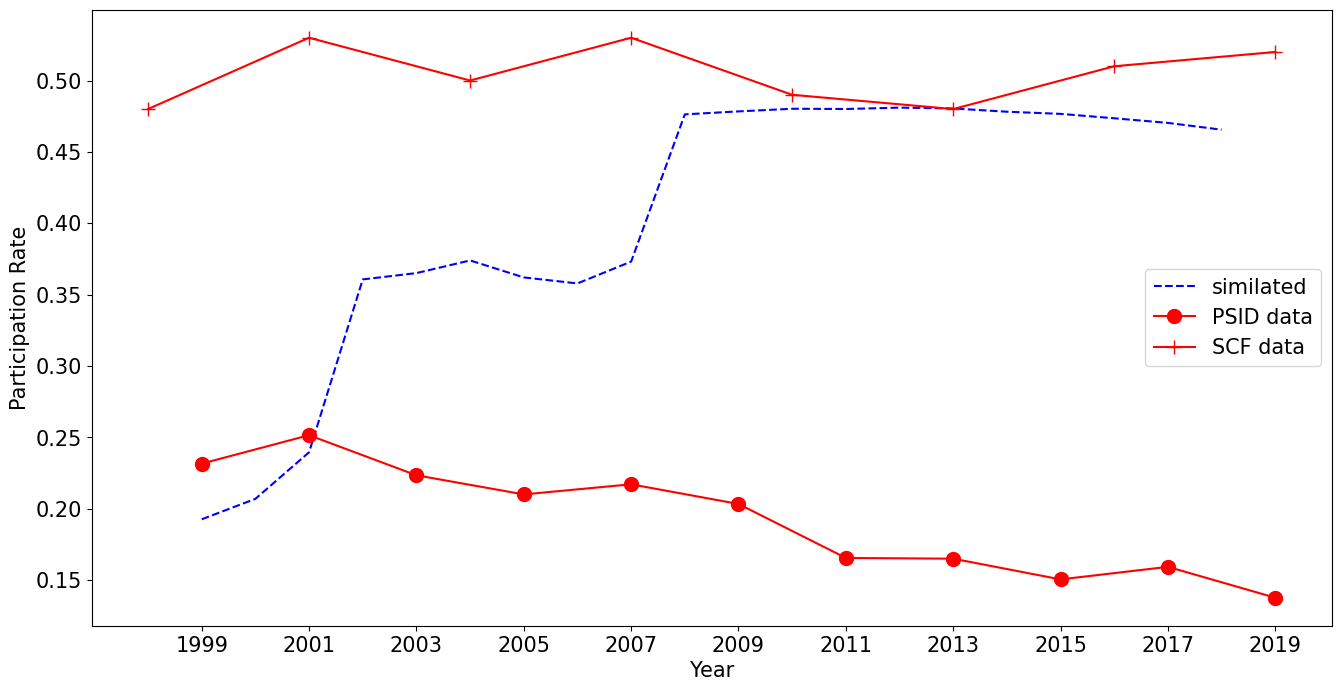

In [116]:
value = participationCollect
targetValue = participation_mean
title = "Participation Rate Plot"
plt.figure()
#plt.title(title)
plt.xticks(years)
plt.xlabel("Year")
plt.ylabel("Participation Rate")
upperBound = value.max(axis = 0) 
lowerBound = value.min(axis = 0)
if len(lowerBound) == 10:
    #plt.fill_between(range(1999, 2019, 2), lowerBound, upperBound)
    plt.plot(range(1999, 2019, 2),value[i], "b--", label = "similated")
elif len(lowerBound) == 20:
    #plt.fill_between(range(1999, 2019), lowerBound, upperBound)
    plt.plot(range(1999, 2019),value[i], "b--", label = "similated")
else:
    #plt.fill_between(range(1999, 2020), lowerBound, upperBound)
    plt.plot(range(1999, 2020),value[i], "b--", label = "similated")
if(len(targetValue)==10):
    plt.plot(range(1999, 2019, 2), targetValue, "ro-",markersize = 10, label = "PSID data")
else:
    plt.plot(years, targetValue, "ro-",markersize = 10, label = "PSID data")  

scfDatayear = np.array([1998,2001,2004,2007,2010,2013,2016,2019])
scfDataP = np.array([0.48, 0.53, 0.50,0.53,0.49,0.48,0.51,0.52])
plt.plot(scfDatayear, scfDataP, "r+-", label = "SCF data", markersize = 10)
plt.legend()

### cross age simulation 

In [132]:
nameMap = dict(zip(AgentType, ["Type-L", "Type-L-LowCost", "Type-H-HighCost", "Type-H"]))
lineStypeMap = dict(zip(AgentType, ["o-", "-.", ":", "*-"]))

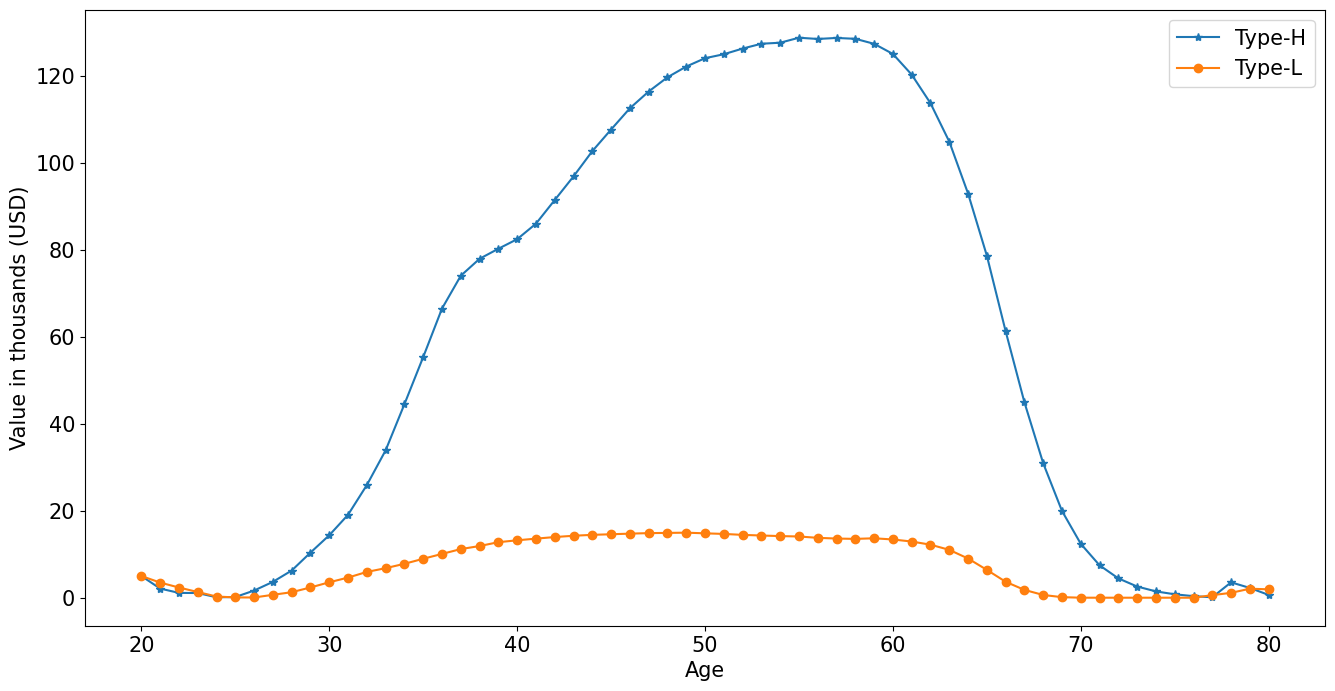

In [136]:
from matplotlib import pyplot as plt
T_max = 60
# housing unit
H = 1000
# housing price constant 
pt = 2*250/1000
Gamma = [4.0]
Beta_r = [0.02]
for gamma in Gamma:
    for beta_r in Beta_r:
        for agentType in ["richLow", "poorHigh"]:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("solution/parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            startAge = 20
            # value of states, state has one more value, since the terminal state does not have associated action
            #plt.title("mean wealth level")
            plt.ylabel("Value in thousands (USD)")
            plt.xlabel("Age")
            plt.plot(range(startAge, T_max + startAge+1),np.mean(wwww,axis = 1), lineStypeMap[agentType], label = nameMap[agentType])
plt.legend()
plt.savefig("plots/meanWealthLevel.jpg")

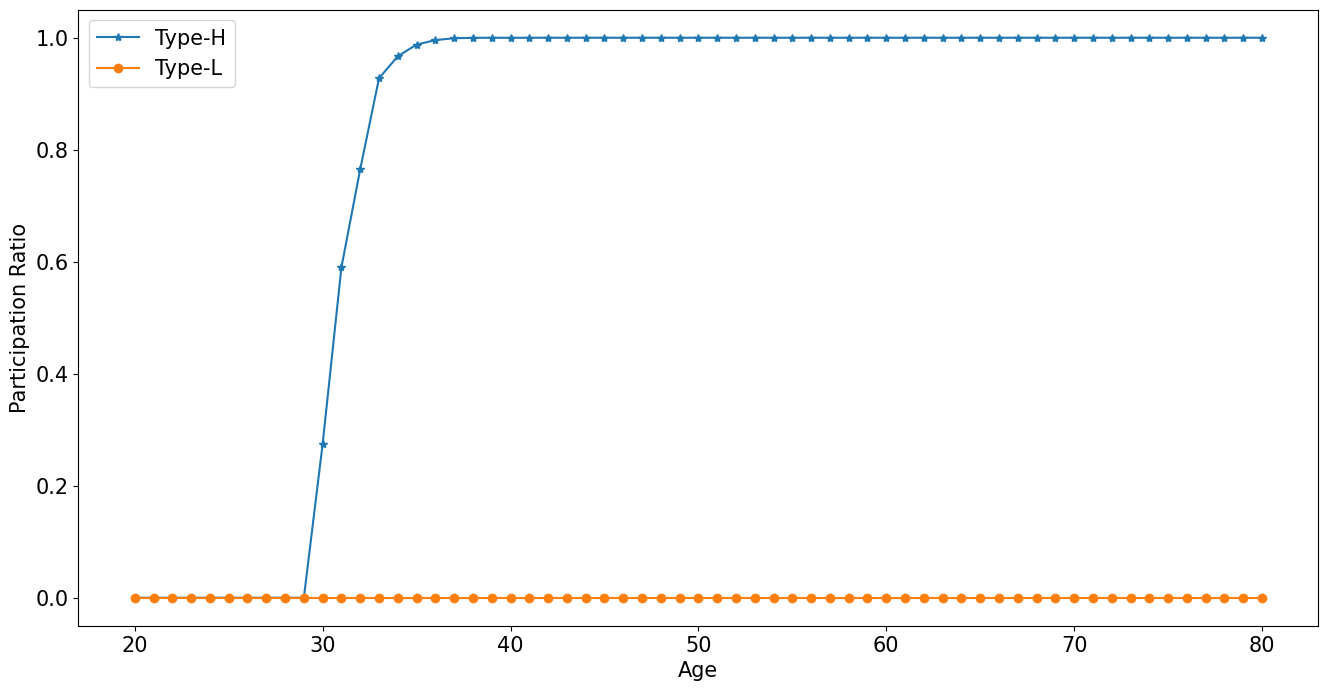

In [137]:
for gamma in Gamma:
    for beta_r in Beta_r:
        for agentType in ["richLow", "poorHigh"]:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("solution/parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            startAge = 20
            # value of states, state has one more value, since the terminal state does not have associated action
            #plt.title("mean stock experience level")
            plt.ylabel("Participation Ratio")
            plt.xlabel("Age")
            plt.plot(range(startAge, T_max + startAge+1),np.mean(zzzz,axis = 1),lineStypeMap[agentType], label = nameMap[agentType])
plt.legend()
plt.savefig("plots/meanStockExperienceLevel.jpg")

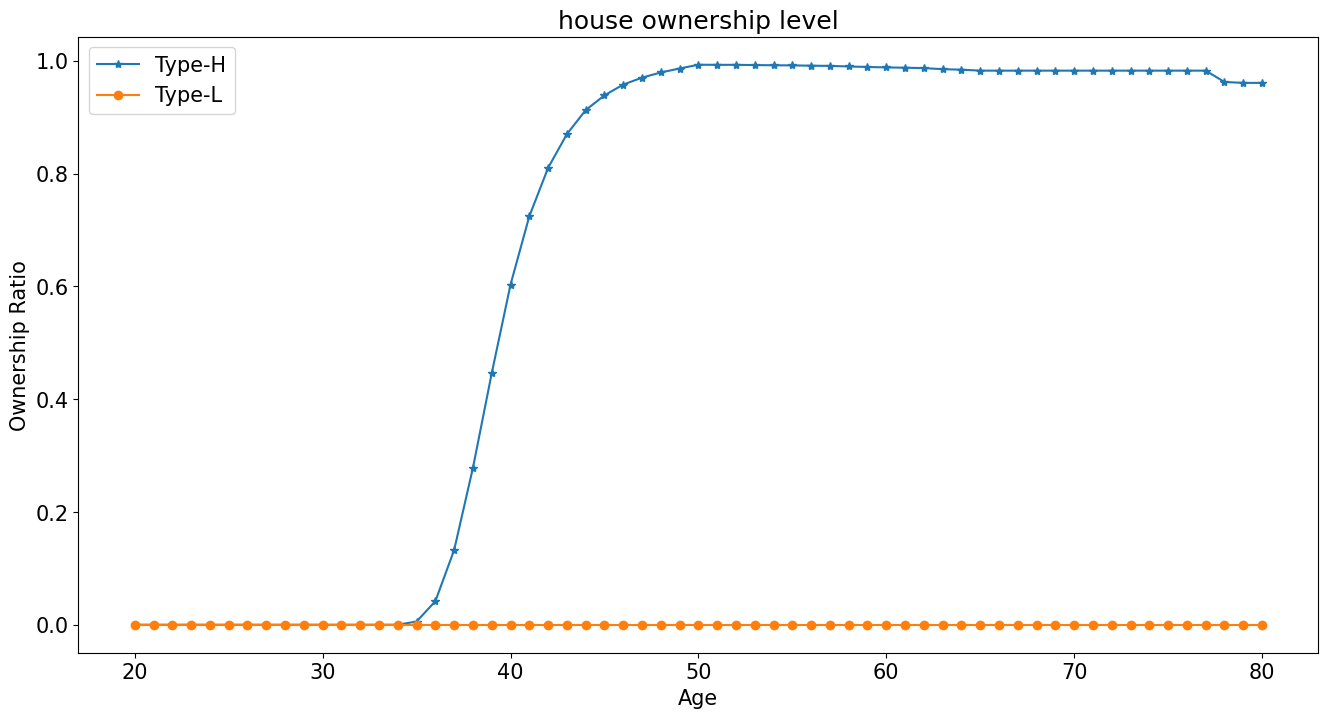

In [138]:
for gamma in Gamma:
    for beta_r in Beta_r:
        for agentType in ["richLow", "poorHigh"]:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("solution/parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            startAge = 20
            # value of states, state has one more value, since the terminal state does not have associated action
            plt.title("house ownership level")
            plt.ylabel("Ownership Ratio")
            plt.xlabel("Age")
            plt.plot(range(startAge, T_max + startAge+1),np.mean(oooo,axis = 1), lineStypeMap[agentType], label = nameMap[agentType])
plt.legend()
plt.savefig("plots/meanHouseOwnership.jpg")

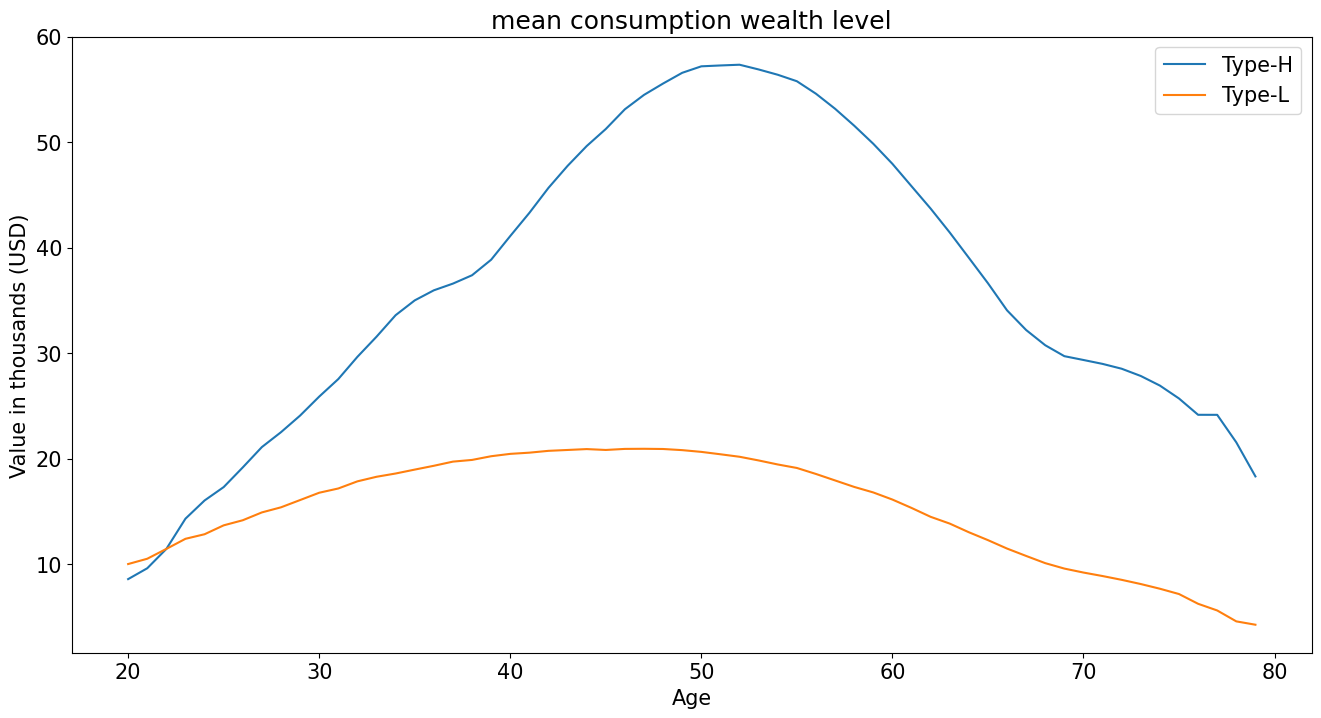

In [ ]:
for gamma in Gamma:
    for beta_r in Beta_r:
        for agentType in ["richLow", "poorHigh"]:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("solution/parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            startAge = 20
            # value of states, state has one more value, since the terminal state does not have associated action
            plt.title("mean consumption wealth level")
            plt.ylabel("Value in thousands (USD)")
            plt.xlabel("Age")
            plt.plot(range(startAge, T_max + startAge),np.mean(cccc,axis = 1), lineStypeMap[agentType], label = nameMap[agentType])
plt.legend()
plt.savefig("plots/meanConsumption.jpg")

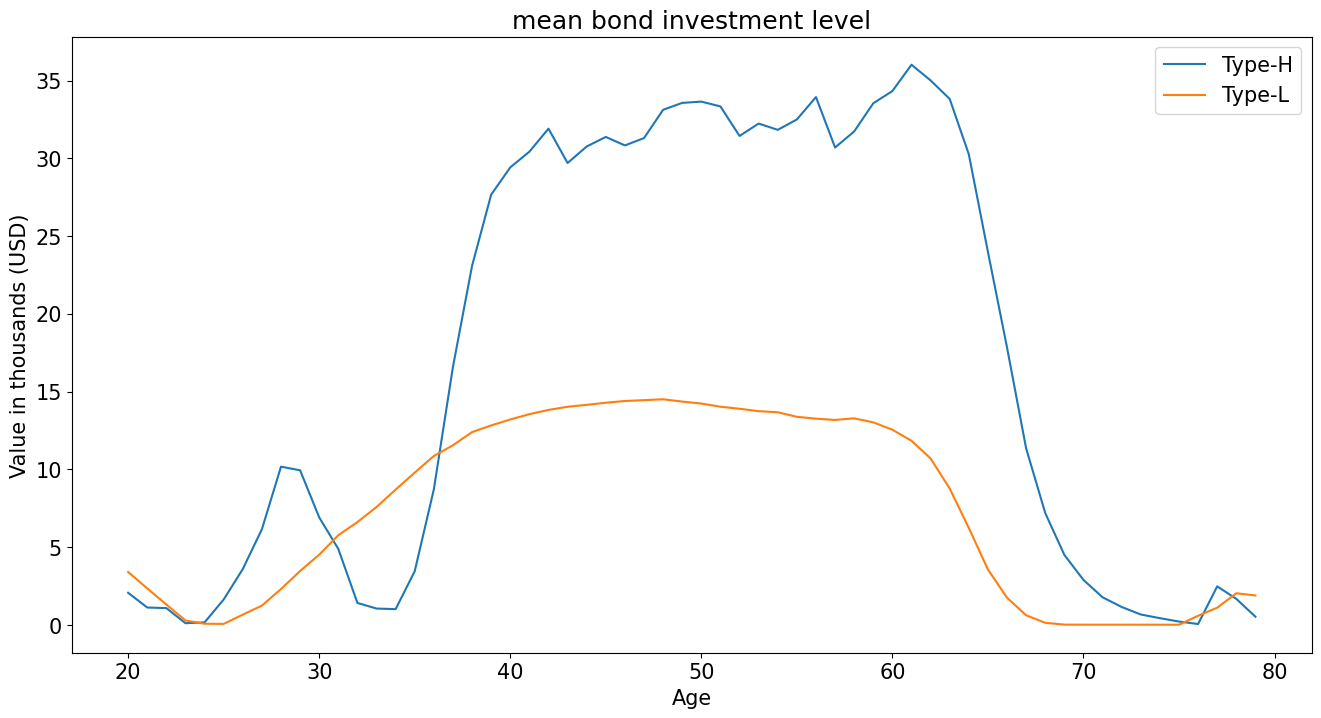

In [ ]:
for gamma in Gamma:
    for beta_r in Beta_r:
        for agentType in ["richLow", "poorHigh"]:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("solution/parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            startAge = 20
            # value of states, state has one more value, since the terminal state does not have associated action
            plt.title("mean bond investment level")
            plt.ylabel("Value in thousands (USD)")
            plt.xlabel("Age")
            plt.plot(range(startAge, T_max + startAge),np.mean(bbbb,axis = 1), label = nameMap[agentType])
plt.legend()
plt.savefig("plots/meanBond.jpg")

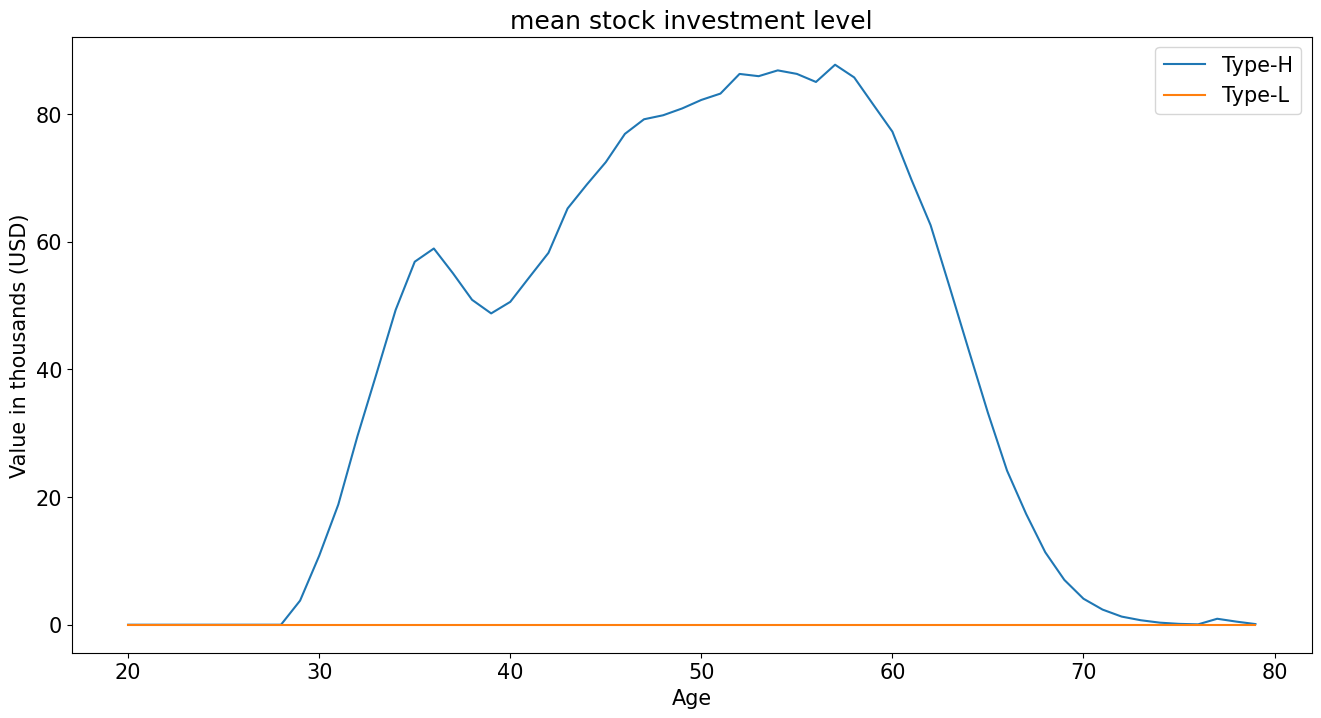

In [ ]:
for gamma in Gamma:
    for beta_r in Beta_r:
        for agentType in ["richLow", "poorHigh"]:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("solution/parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            startAge = 20
            # value of states, state has one more value, since the terminal state does not have associated action
            plt.title("mean stock investment level")
            plt.ylabel("Value in thousands (USD)")
            plt.xlabel("Age")
            plt.plot(range(startAge, T_max + startAge),np.mean(kkkk,axis = 1), label = nameMap[agentType])
plt.legend()
plt.savefig("plots/meanStock.jpg")

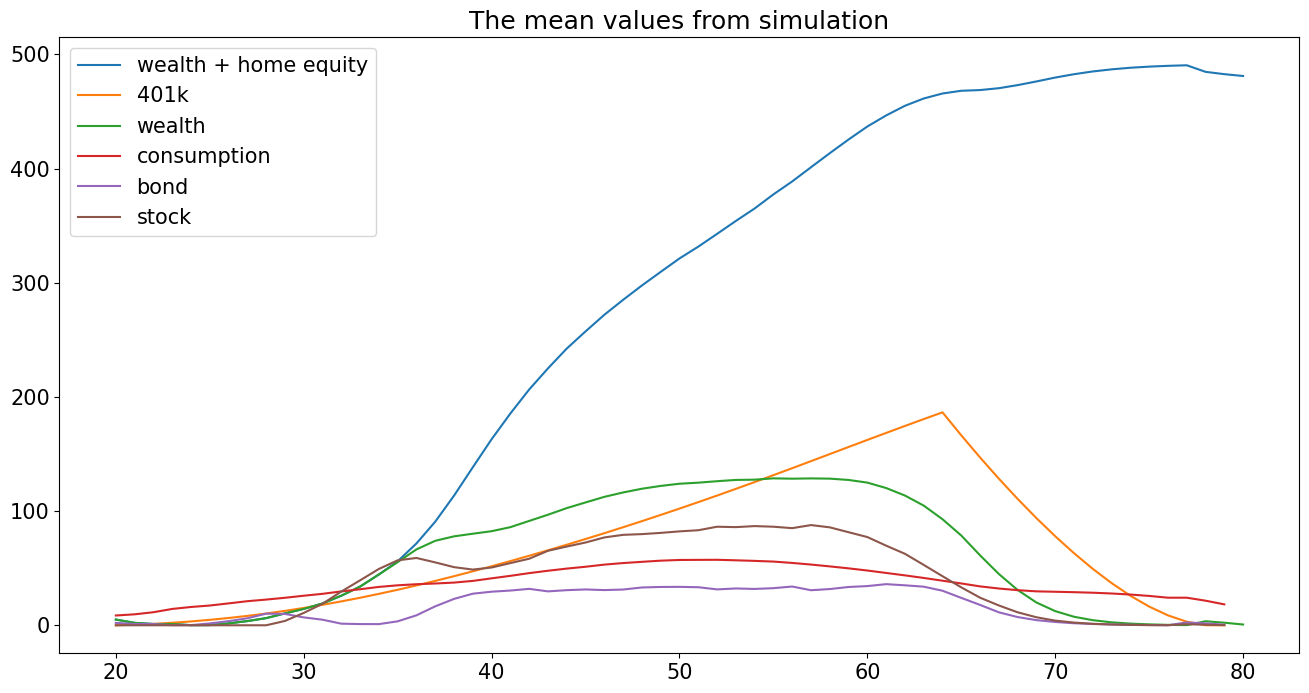

In [ ]:

for gamma in Gamma:
    for beta_r in Beta_r:
        for agentType in ["richLow"]:
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("solution/parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            plt.figure()
            plt.title("The mean values from simulation")
            plt.plot(range(20, T_max + 21),jnp.mean(wwww + H*pt*oooo - mmmm,axis = 1), label = "wealth + home equity")
            plt.plot(range(20, T_max + 20),a, label = "401k")
            plt.plot(range(20, T_max + 21),jnp.mean(wwww,axis = 1), label = "wealth")
            plt.plot(range(20, T_max + 20),jnp.mean(cccc,axis = 1), label = "consumption")
            plt.plot(range(20, T_max + 20),jnp.mean(bbbb,axis = 1), label = "bond")
            plt.plot(range(20, T_max + 20),jnp.mean(kkkk,axis = 1), label = "stock")
            plt.legend()
            plt.savefig("meanValueSimulation")